<a href="https://colab.research.google.com/github/Varnez/final-degree-project/blob/master/models/mnist_CGAN_paper_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CGAN
Convolutional Generational Adversarial Model recreated from the paper 'Unsupervised representation learning with conv Gan' and further augmented with the insight of the following paper 'NIPS 2016 Tutorial: Generative Adversarial Networks'.

## Data Preprocessing
The MNIST dataset is chosen to test this first model.


In [0]:
# Imports
from tensorflow.keras.datasets import mnist
import numpy as np


In [0]:
# Data hyperparameters
img_width = 28
img_height = 28
img_channels = 1

img_shape = (img_width, img_height, img_channels)

In [0]:
# MNIST dataset images loading
(x_train, _), _ = mnist.load_data()

# Dataset reshaping
x_train = x_train.reshape(-1, img_height, img_width, img_channels).astype(np.float32)

# Dataset normalization into the Tanh function output range ([-1, 1])
x_train = 2. * (x_train - np.min(x_train)) / np.ptp(x_train) - 1

## Model Instatiation

In [0]:
# Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Activation, LeakyReLU
from tensorflow.keras.layers import Reshape, Flatten, UpSampling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.activations import relu, tanh
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.optimizers import Adam

In [0]:
# Model hyperparameters
# Common
dropout_rate = 0.4
norm_momentum = 0.9
optimizer_momentum = 0.5
learning_rate = 0.0002
lrelu_alpha = 0.2

# Generator
gen_depth = 128
gen_kernel_size = 5

# Discriminator
dis_depth = 32
gen_kernel_size = 5


### Generator

The number of Transposed Convolutional layers have been reduced from four to two in order to match the size of the images of the MNIST dataset.

In [0]:
def build_generator_model():
  G = Sequential()

  G.add(Dense(7*7*gen_depth, input_dim=(100)))
  G.add(BatchNormalization(momentum=norm_momentum))
  G.add(Activation('relu'))
  G.add(Dropout(dropout_rate))

  # Project and Reshape
  G.add(Reshape((7, 7, gen_depth)))
  
  # CONV 1
  G.add(Conv2DTranspose(gen_depth//2, kernel_size=gen_kernel_size, strides=2, padding="same"))
  G.add(BatchNormalization(momentum=norm_momentum))
  G.add(Activation('relu'))
  G.add(Dropout(dropout_rate))

  # CONV 2
  G.add(Conv2DTranspose(img_channels, kernel_size=gen_kernel_size, strides=2, padding="same"))
  G.add(Activation('tanh'))
  
  return G

In [27]:
G = build_generator_model()
G.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
batch_normalization_2 (Batch (None, 6272)              25088     
_________________________________________________________________
activation_4 (Activation)    (None, 6272)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)       

### Discriminator
Although characteristics for the discriminator model where explicity recommended in the paper, there is no specific architecture to follow. 

In that matter, the model have been resolved into simple convolutional classification, following, of course, the characteristics stated.

Something important to be noted is that the model deviates from the pape's recommendations from not having batch normalization in all of its layers excepting the input one. Whenever this batch normalization have been used, as much as the discriminator had very good results, the generator was unable to learn to properly produce number images, getting stuck in always generating a random image which was very good at fooling the discriminator.


In [0]:
def build_discriminator_model():
  D = Sequential()

  D.add(Conv2D(dis_depth, kernel_size=gen_kernel_size, input_shape=img_shape, strides=2, padding='same'))
  D.add(LeakyReLU(alpha=lrelu_alpha))
  D.add(Dropout(dropout_rate))

  D.add(Conv2D(dis_depth*2, kernel_size=gen_kernel_size, strides=2, padding='same'))
  D.add(LeakyReLU(alpha=lrelu_alpha))
  D.add(Dropout(dropout_rate))

  D.add(Conv2D(dis_depth*4, kernel_size=gen_kernel_size, strides=2, padding='same'))
  D.add(LeakyReLU(alpha=lrelu_alpha))
  D.add(Dropout(dropout_rate))

  D.add(Conv2D(dis_depth*8, kernel_size=gen_kernel_size, strides=2, padding='same'))
  D.add(LeakyReLU(alpha=lrelu_alpha))
  D.add(Dropout(dropout_rate))

  D.add(Flatten())
  D.add(Dense(1))
  D.add(Activation('sigmoid'))
  
  return D

In [29]:
D = build_discriminator_model()
D.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)        

## Models

In [0]:
Discriminator = Sequential()

Discriminator.add(D)
Discriminator.compile(loss='binary_crossentropy', 
                      optimizer=Adam(lr=learning_rate, beta_1=optimizer_momentum),
                      metrics = ['accuracy'])

In [0]:
Adversarial = Sequential()

Adversarial.add(G)
D.trainable = False
Adversarial.add(D)
Adversarial.compile(loss='binary_crossentropy', 
                    optimizer=Adam(lr=learning_rate, beta_1=optimizer_momentum),
                    metrics = ['accuracy'])

In [0]:
Generator = G

## Training

In [0]:
# Section imports
import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
# Training hyperparamenters
train_steps = 50000
batch_size = 64
  
gen_training_interval = 1
dis_training_interval = 5

print_output_interval = 1000

# Training intervals for each model can be changed halfway the training process
reduce_training_interval = False
gen_training_interval_reduction = 1
dis_training_interval_reduction = 1

In [0]:
def plot_images(save_img=False,
                fake=True, 
                samples=16, 
                noise=None, 
                step=0,
                filename='generation  ' + str(datetime.datetime.now()) + '.png'):
  
  if fake:
    if noise is None:
      noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
      
    images = Generator.predict(noise)
    
  else:
    i = np.random.randint(0, x_train.shape[0], samples)
    images = x_train[i, :, :, :]

  plt.figure(figsize=(10,10))
  
  for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_height, img_width])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
  plt.tight_layout()
  
  if save_img:
    plt.savefig(filename)
    plt.close('all')
    
  else:
    plt.show()

In [0]:
def train_generator(Adversarial, batch_size):
  y = np.ones([batch_size, 1])
  noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
  
  a_loss = Adversarial.train_on_batch(noise, y)
  
  return a_loss

In [0]:
def train_discriminator(Discriminator, Generator, x_train, batch_size):
  images_train = x_train[np.random.randint(0, x_train.shape[0], size=batch_size), :, :, :]
  noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
  images_fake = Generator.predict(noise)
  
  x = np.concatenate((images_train, images_fake))
  y = np.ones([2*batch_size, 1])
  y[batch_size:, :] = 0
  
  d_loss = Discriminator.train_on_batch(x, y)
  
  return d_loss

W0717 17:50:46.924199 140553409275776 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


1000: [D loss: 0.688726, acc: 0.546875]  [A loss: 0.693194, acc: 0.484375]


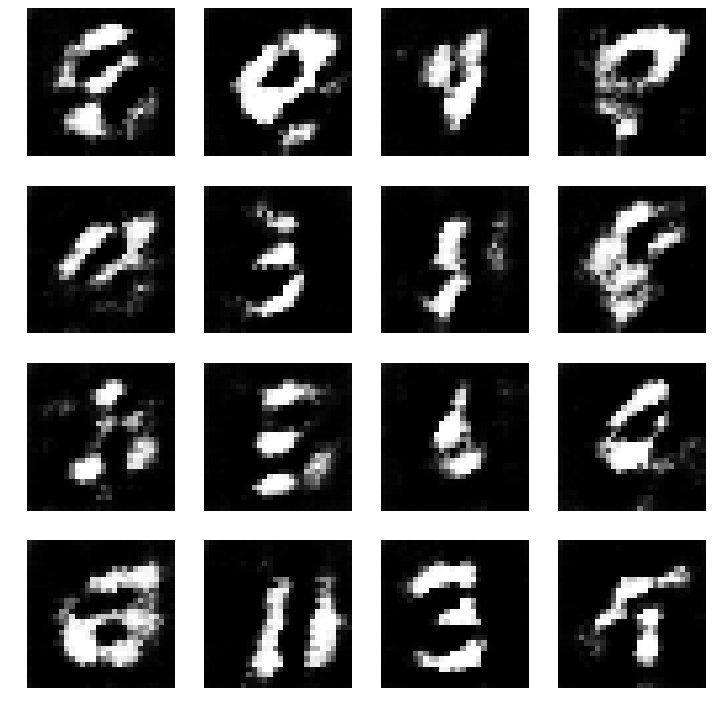

2000: [D loss: 0.691201, acc: 0.523438]  [A loss: 0.707257, acc: 0.468750]


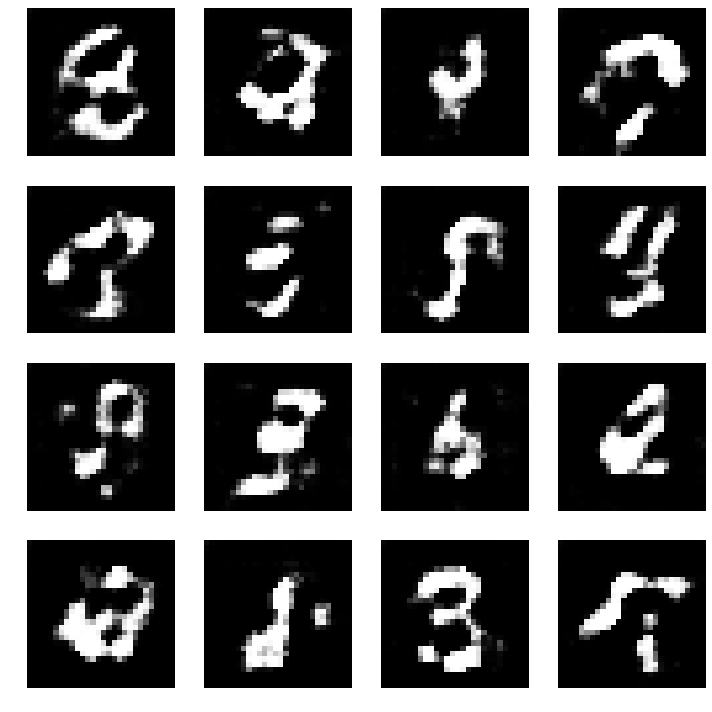

3000: [D loss: 0.678027, acc: 0.554688]  [A loss: 0.707404, acc: 0.437500]


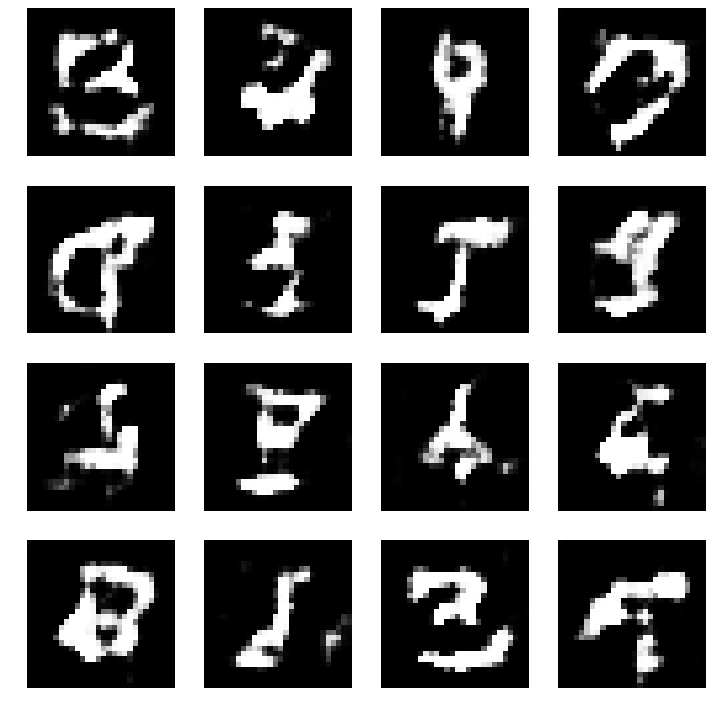

4000: [D loss: 0.692458, acc: 0.562500]  [A loss: 0.764088, acc: 0.265625]


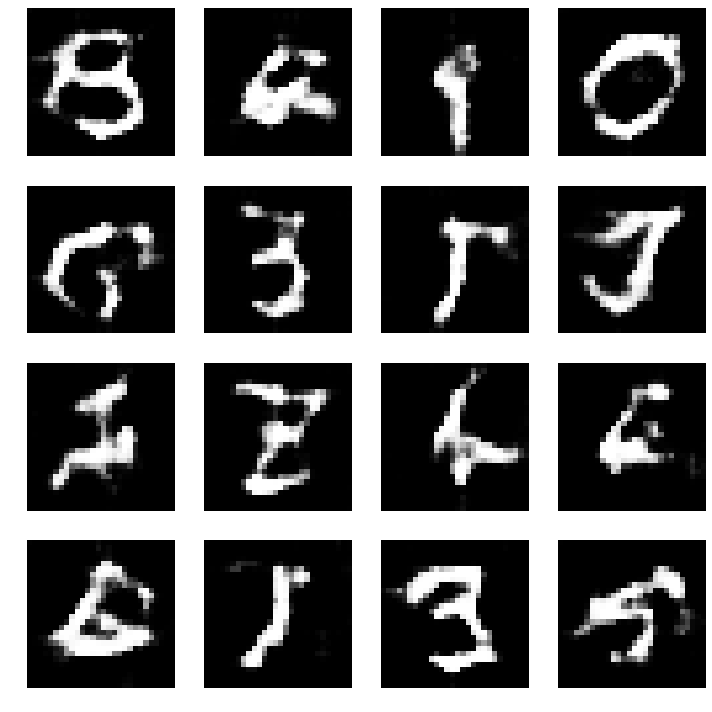

5000: [D loss: 0.678851, acc: 0.523438]  [A loss: 0.770093, acc: 0.312500]


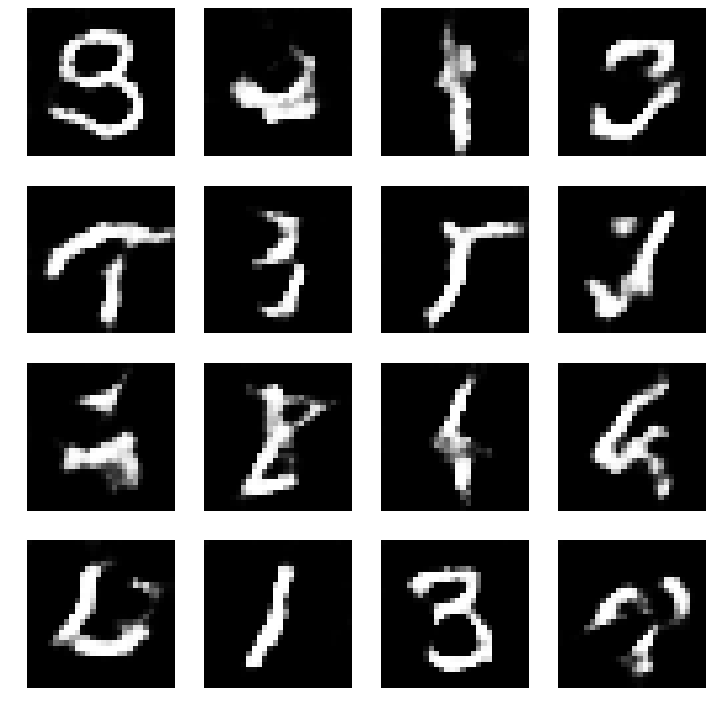

6000: [D loss: 0.701612, acc: 0.492188]  [A loss: 0.722995, acc: 0.375000]


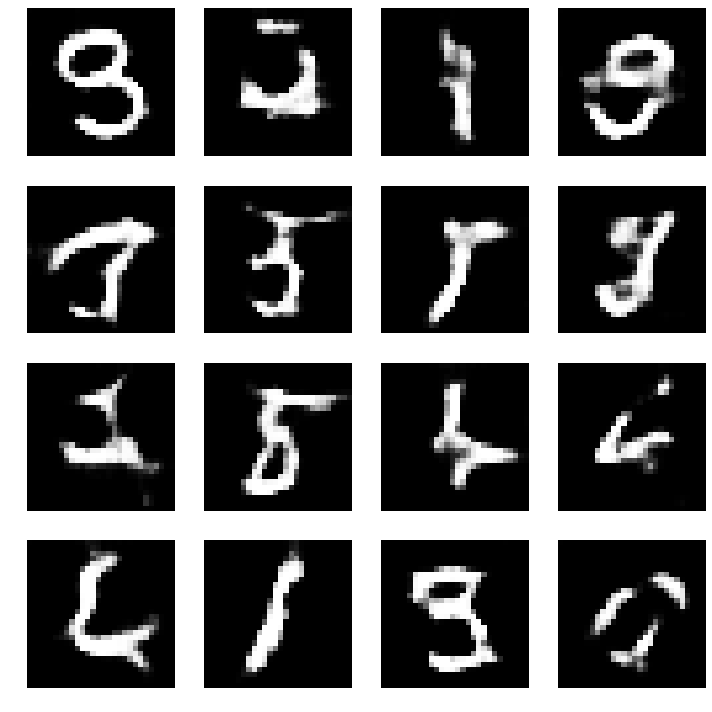

7000: [D loss: 0.680405, acc: 0.531250]  [A loss: 0.760959, acc: 0.203125]


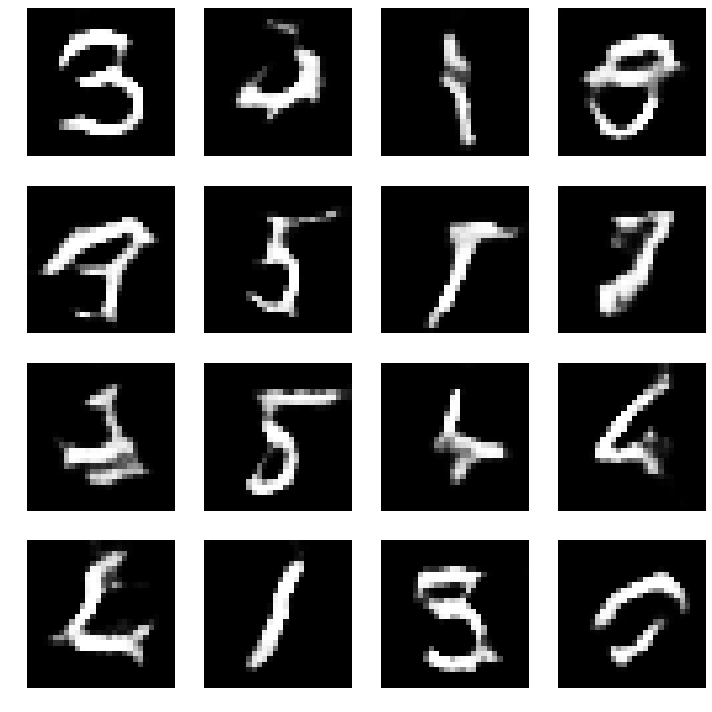

8000: [D loss: 0.676158, acc: 0.570312]  [A loss: 0.787505, acc: 0.312500]


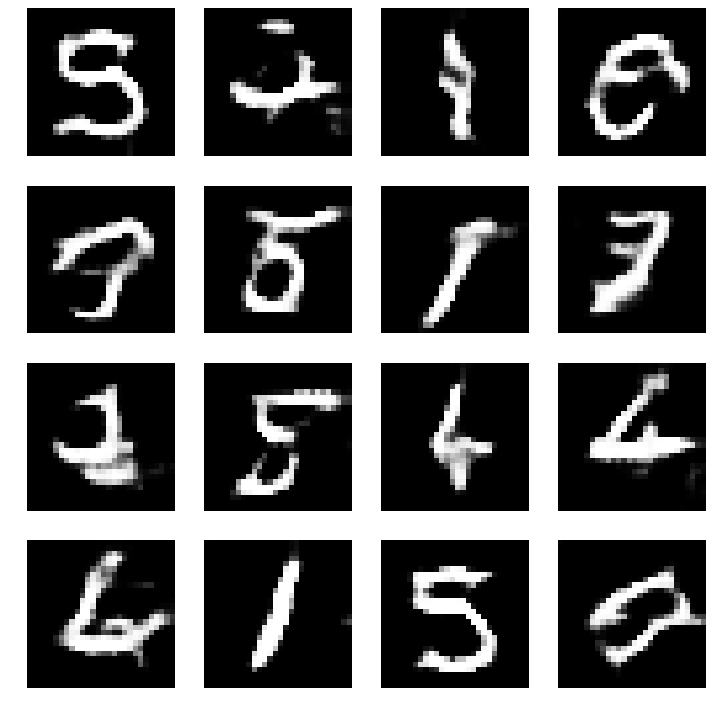

9000: [D loss: 0.671991, acc: 0.578125]  [A loss: 0.752186, acc: 0.343750]


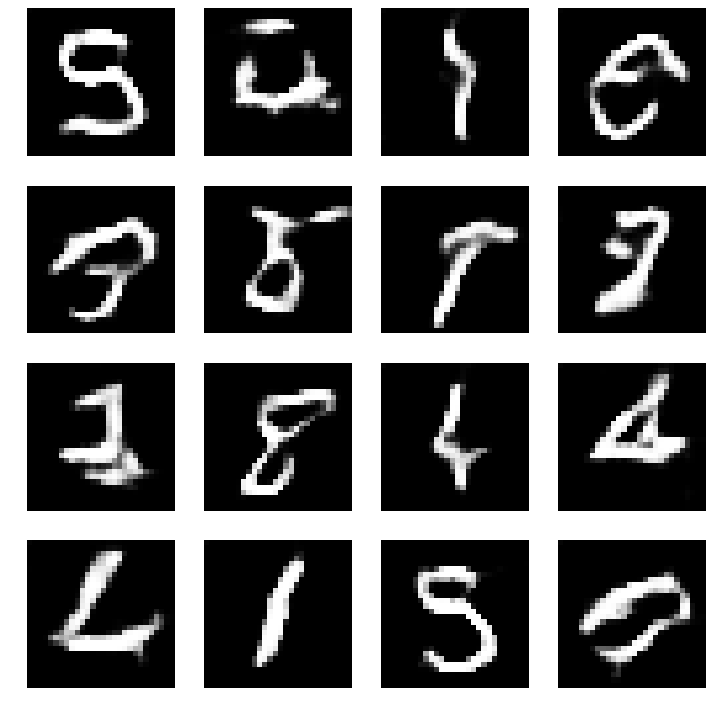

10000: [D loss: 0.678818, acc: 0.539062]  [A loss: 0.738499, acc: 0.390625]


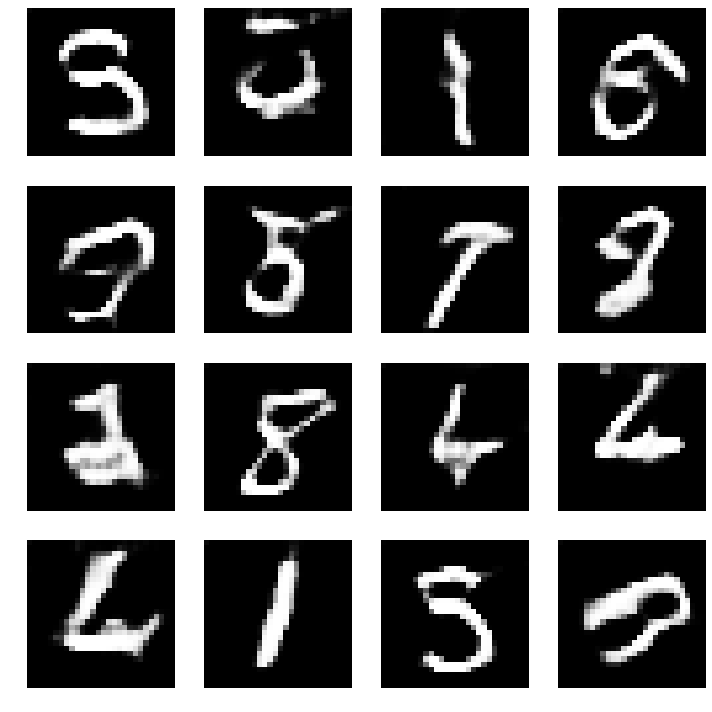

11000: [D loss: 0.688611, acc: 0.539062]  [A loss: 0.822134, acc: 0.187500]


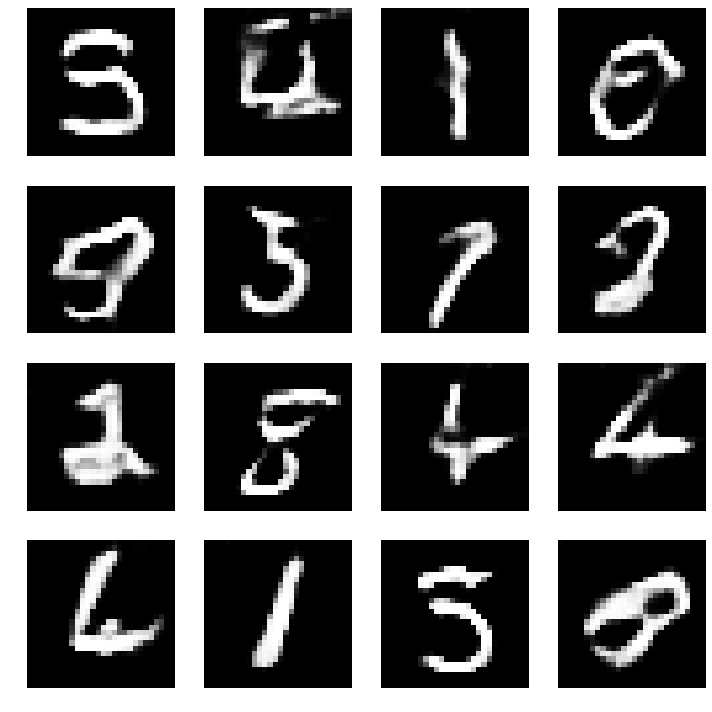

12000: [D loss: 0.707632, acc: 0.570312]  [A loss: 0.874829, acc: 0.156250]


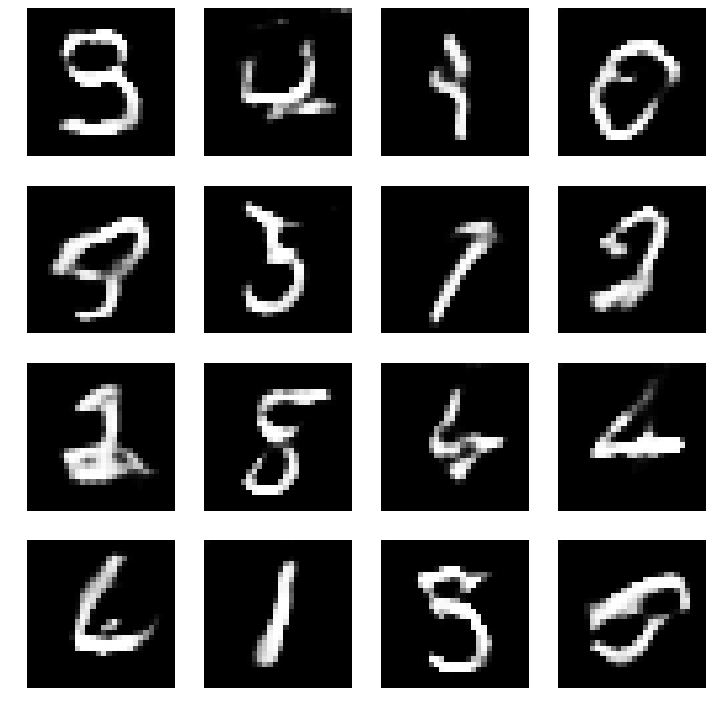

13000: [D loss: 0.682014, acc: 0.578125]  [A loss: 0.849883, acc: 0.281250]


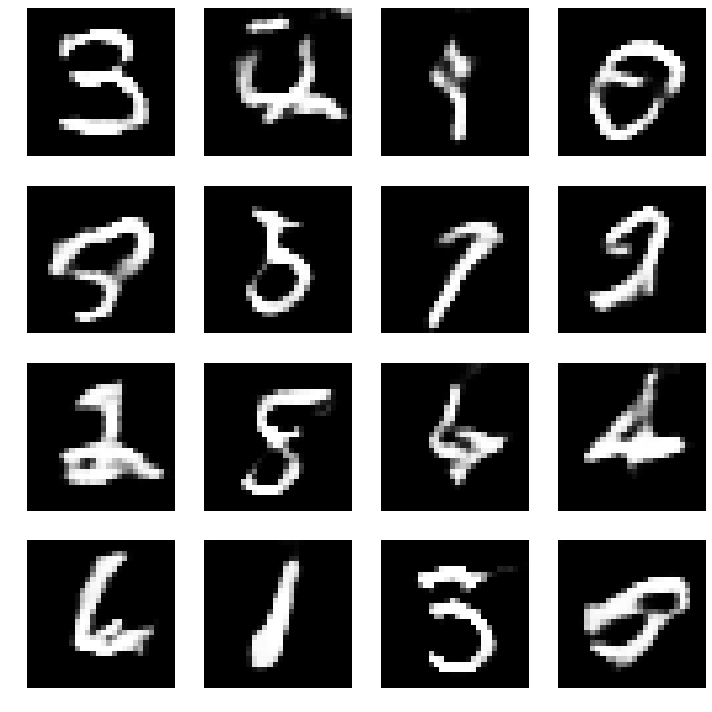

14000: [D loss: 0.656311, acc: 0.593750]  [A loss: 0.727796, acc: 0.468750]


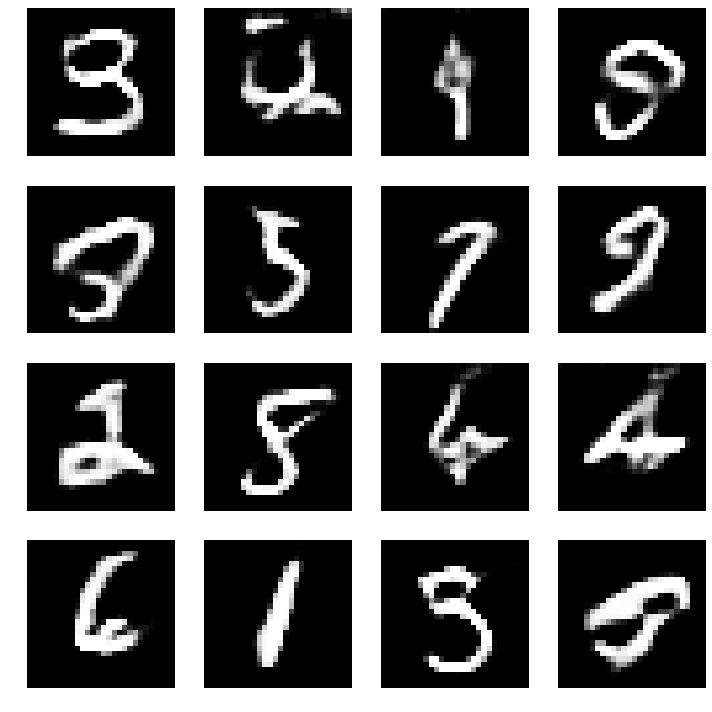

15000: [D loss: 0.679376, acc: 0.578125]  [A loss: 0.780693, acc: 0.328125]


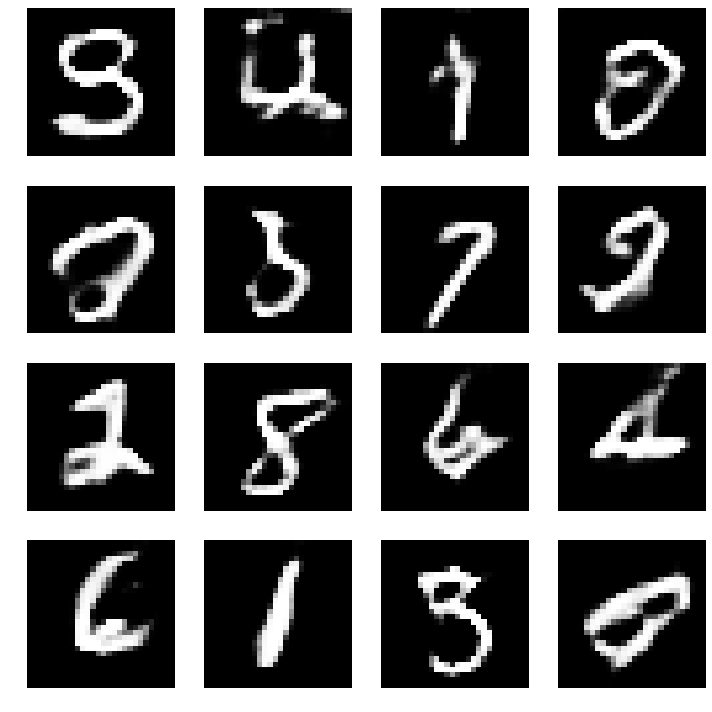

16000: [D loss: 0.653706, acc: 0.656250]  [A loss: 0.889340, acc: 0.250000]


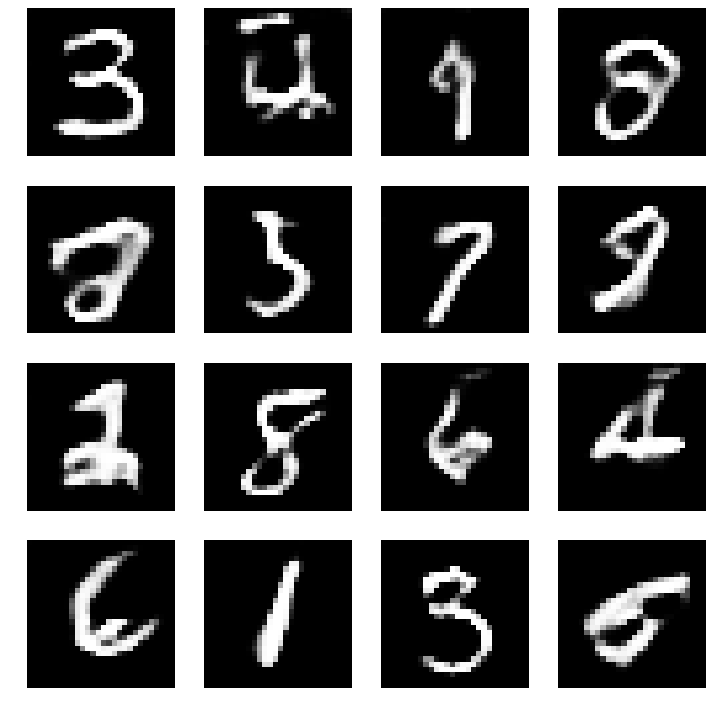

17000: [D loss: 0.672151, acc: 0.609375]  [A loss: 0.864709, acc: 0.281250]


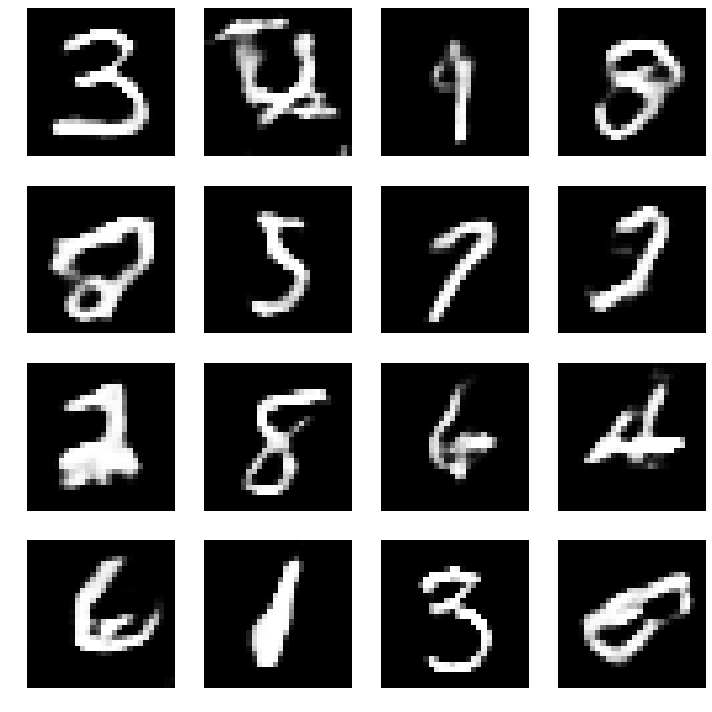

18000: [D loss: 0.653950, acc: 0.601562]  [A loss: 0.790466, acc: 0.312500]


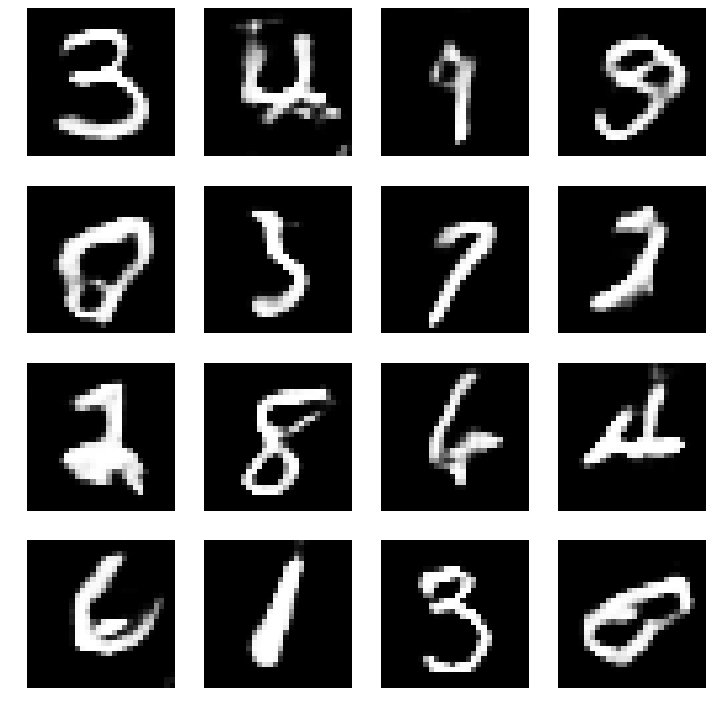

19000: [D loss: 0.661133, acc: 0.609375]  [A loss: 0.986501, acc: 0.156250]


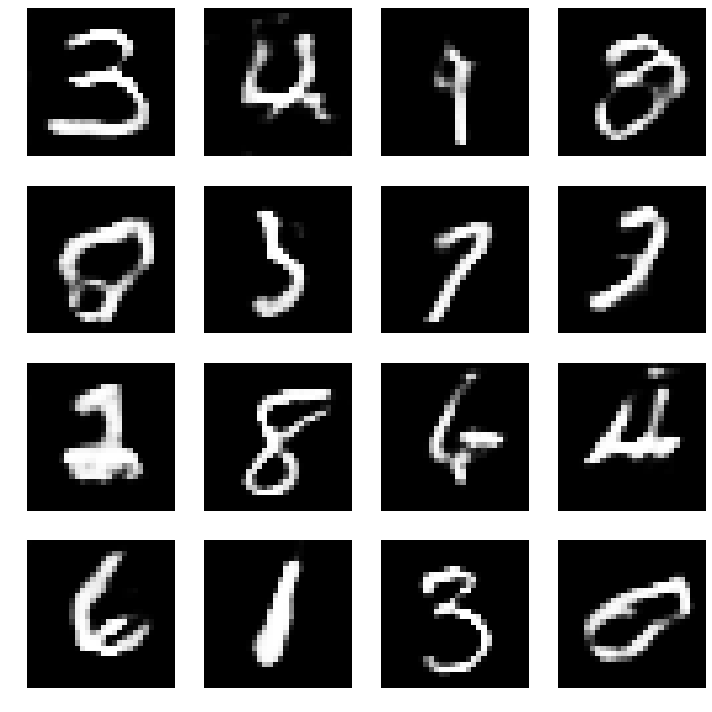

20000: [D loss: 0.657195, acc: 0.601562]  [A loss: 0.862749, acc: 0.343750]


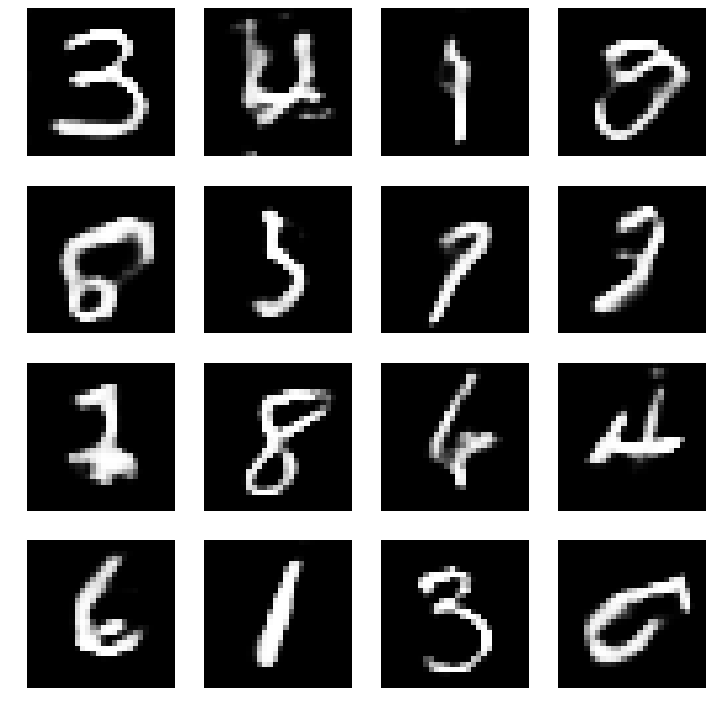

21000: [D loss: 0.635574, acc: 0.687500]  [A loss: 0.884096, acc: 0.250000]


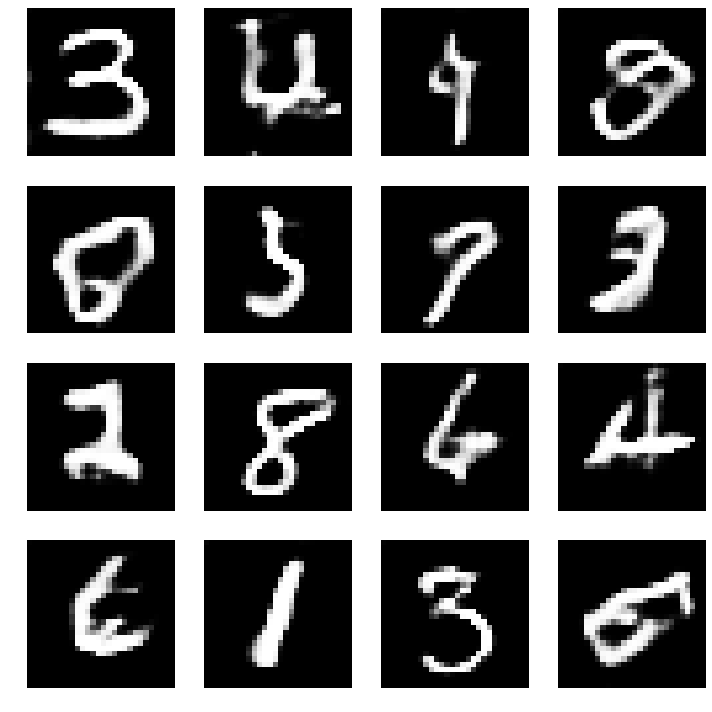

22000: [D loss: 0.624338, acc: 0.640625]  [A loss: 0.851407, acc: 0.281250]


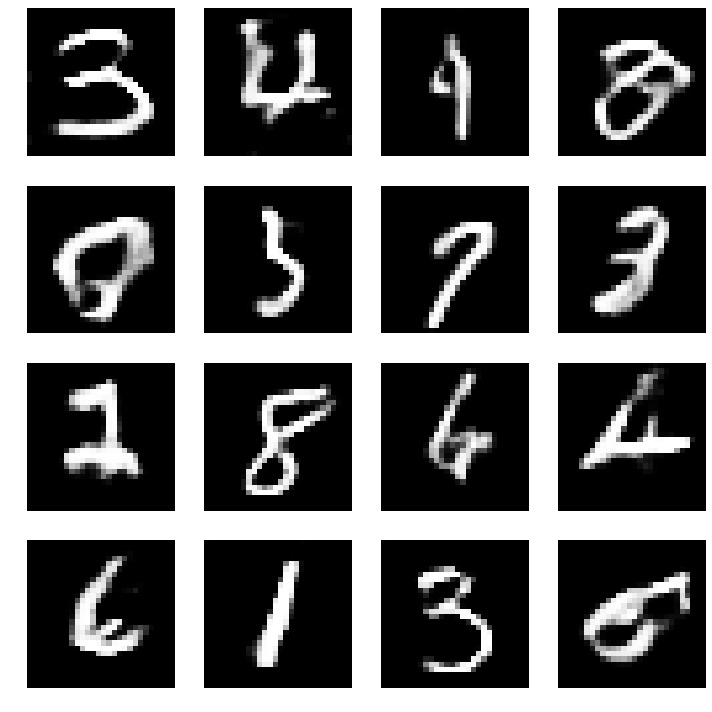

23000: [D loss: 0.642194, acc: 0.664062]  [A loss: 0.865257, acc: 0.312500]


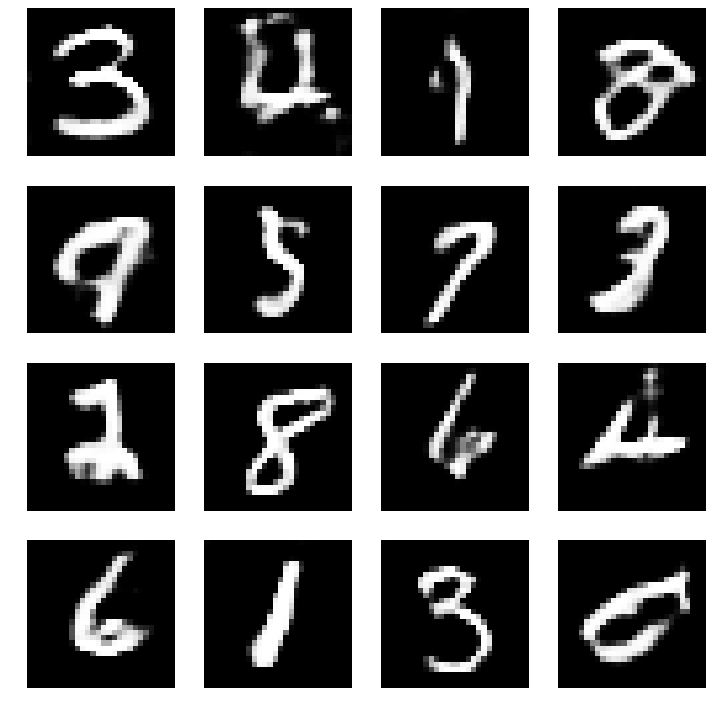

24000: [D loss: 0.636617, acc: 0.640625]  [A loss: 0.870782, acc: 0.218750]


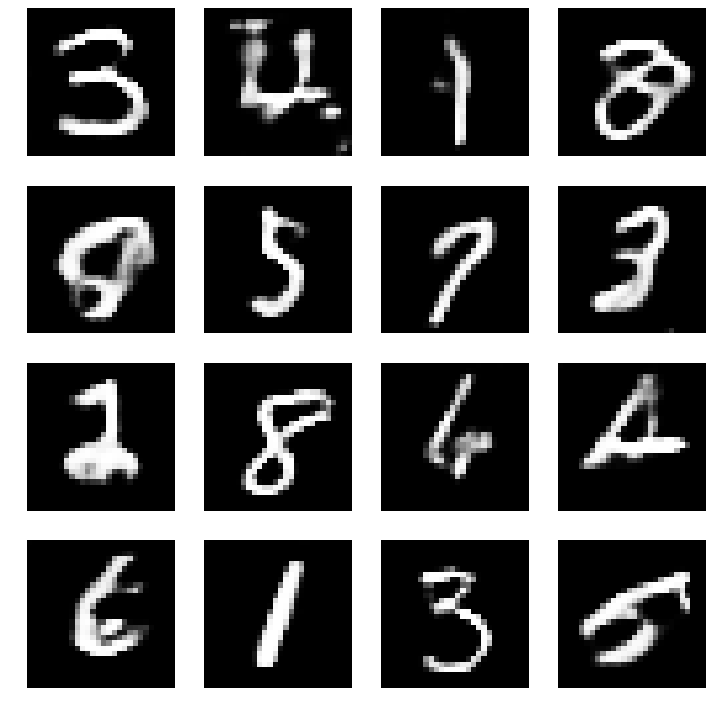

25000: [D loss: 0.661306, acc: 0.585938]  [A loss: 0.891455, acc: 0.265625]


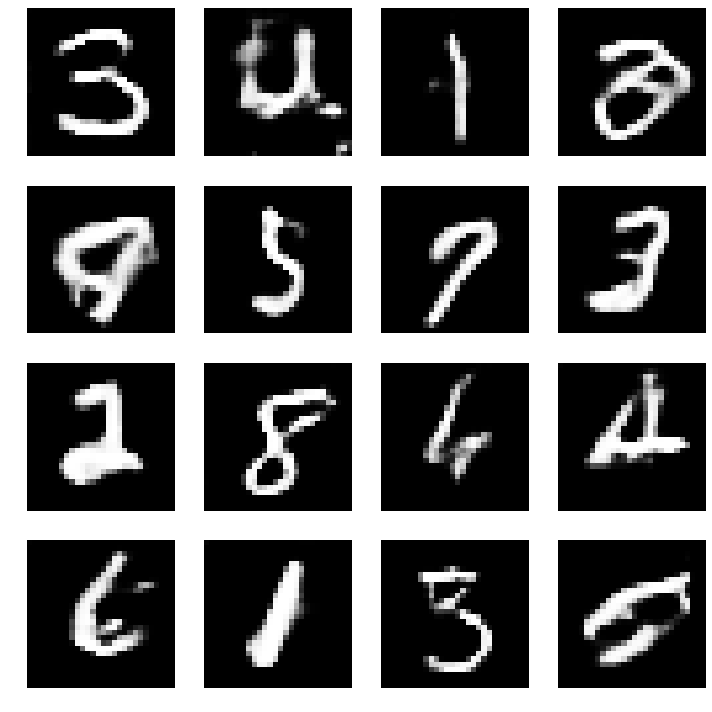

26000: [D loss: 0.666603, acc: 0.617188]  [A loss: 0.861654, acc: 0.312500]


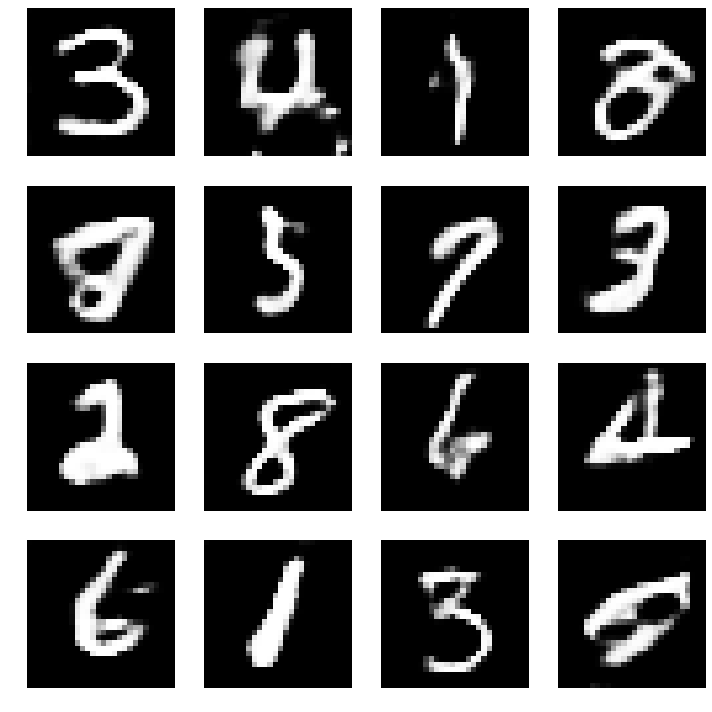

27000: [D loss: 0.619238, acc: 0.640625]  [A loss: 1.000920, acc: 0.125000]


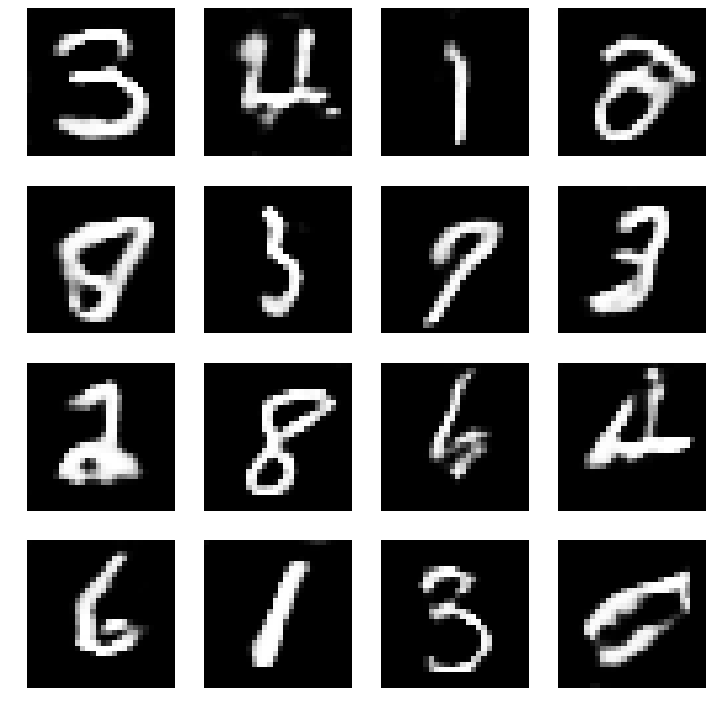

28000: [D loss: 0.629966, acc: 0.625000]  [A loss: 0.853771, acc: 0.296875]


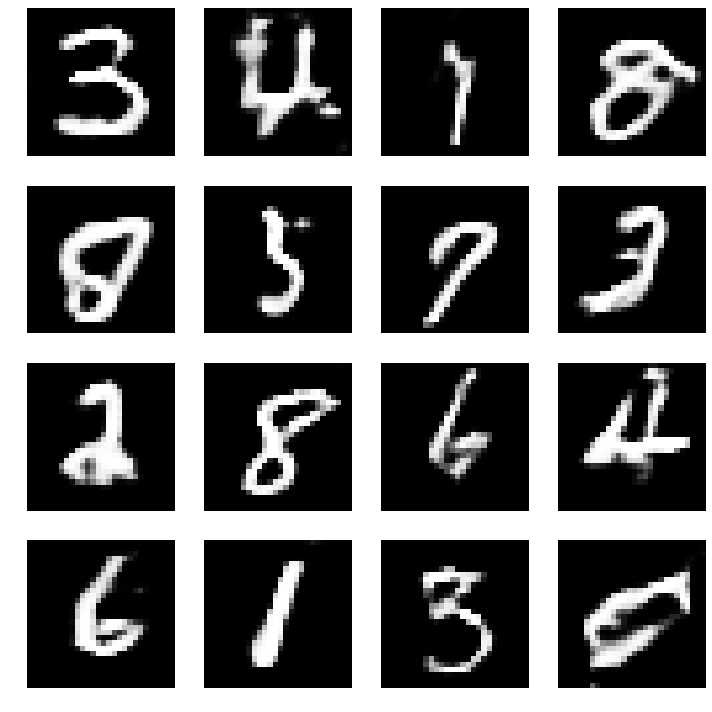

29000: [D loss: 0.635297, acc: 0.617188]  [A loss: 0.913440, acc: 0.171875]


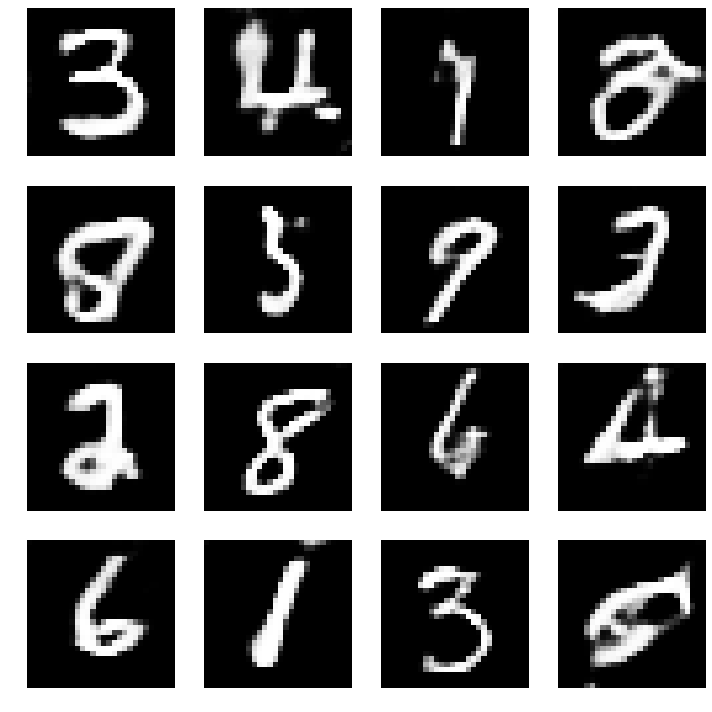

30000: [D loss: 0.593259, acc: 0.679688]  [A loss: 0.950020, acc: 0.171875]


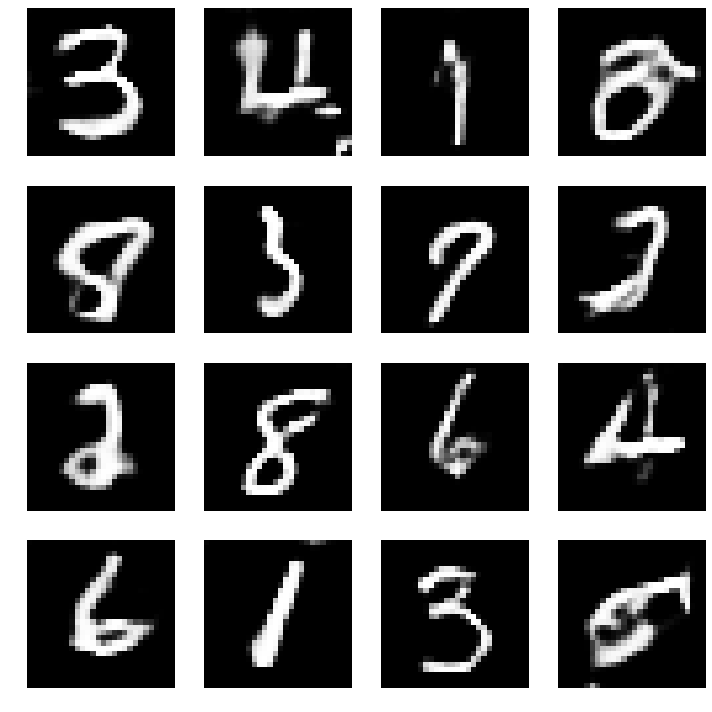

31000: [D loss: 0.627311, acc: 0.710938]  [A loss: 0.888718, acc: 0.328125]


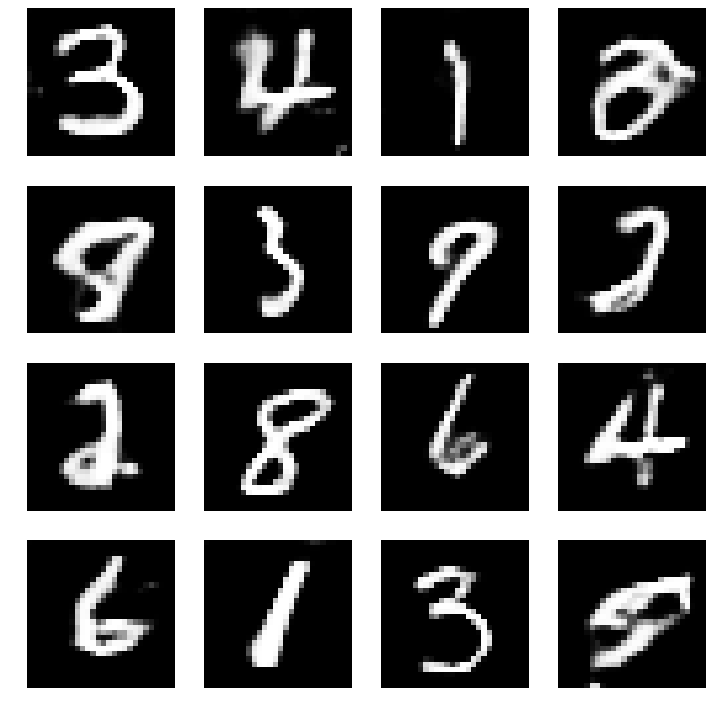

32000: [D loss: 0.627134, acc: 0.648438]  [A loss: 0.983922, acc: 0.203125]


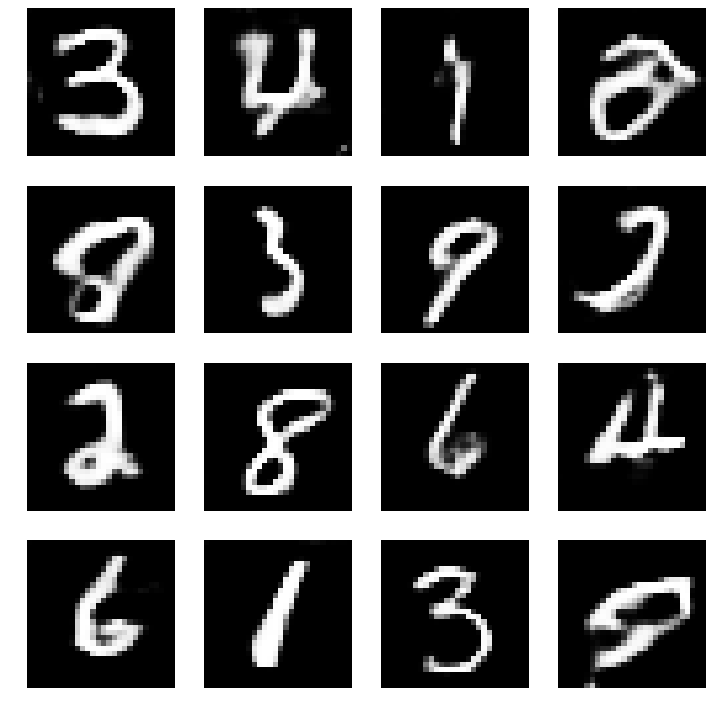

33000: [D loss: 0.629159, acc: 0.648438]  [A loss: 0.820889, acc: 0.375000]


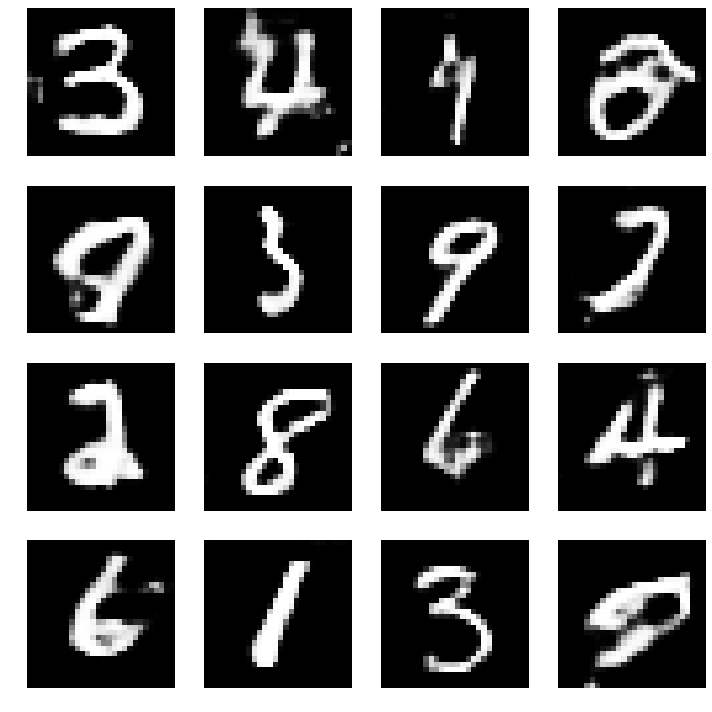

34000: [D loss: 0.632172, acc: 0.648438]  [A loss: 0.952246, acc: 0.187500]


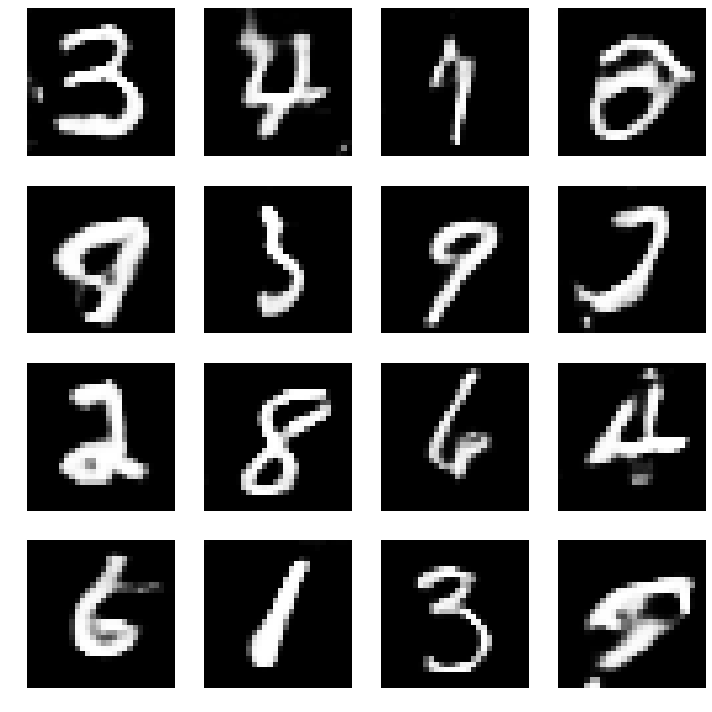

35000: [D loss: 0.665039, acc: 0.656250]  [A loss: 0.981471, acc: 0.218750]


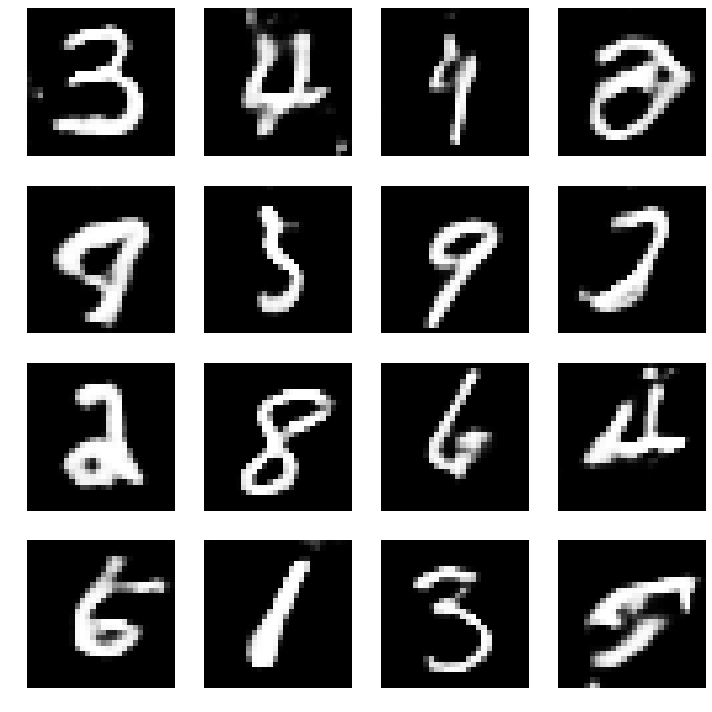

36000: [D loss: 0.677179, acc: 0.562500]  [A loss: 0.966683, acc: 0.203125]


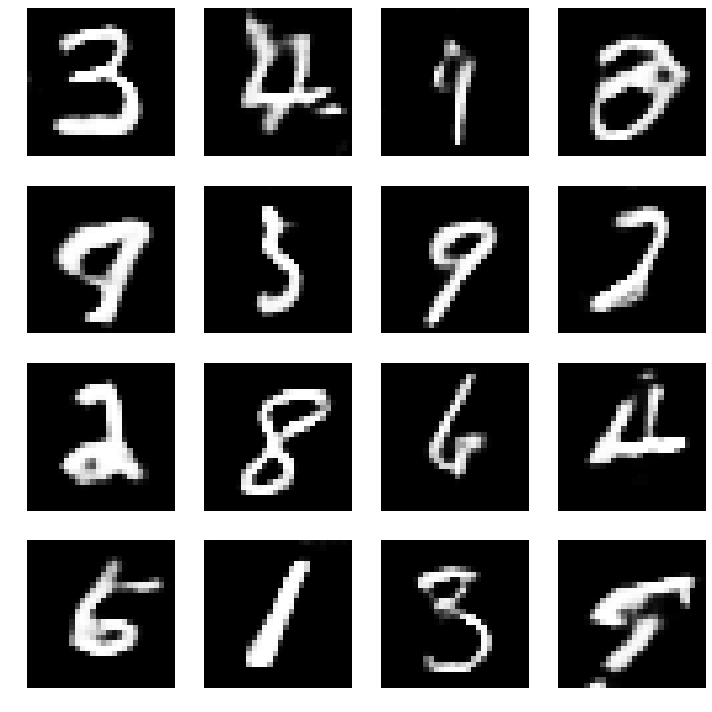

37000: [D loss: 0.633551, acc: 0.625000]  [A loss: 0.939900, acc: 0.265625]


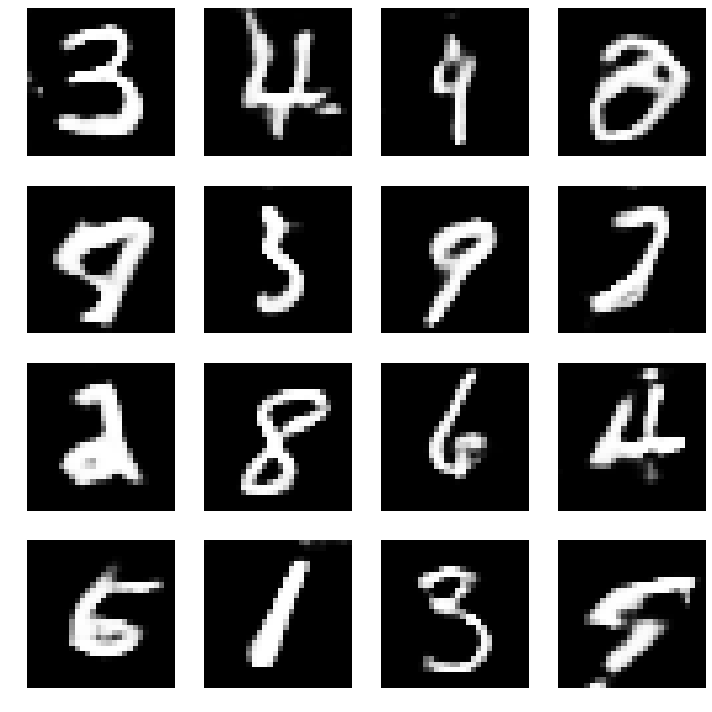

38000: [D loss: 0.633672, acc: 0.664062]  [A loss: 0.980905, acc: 0.203125]


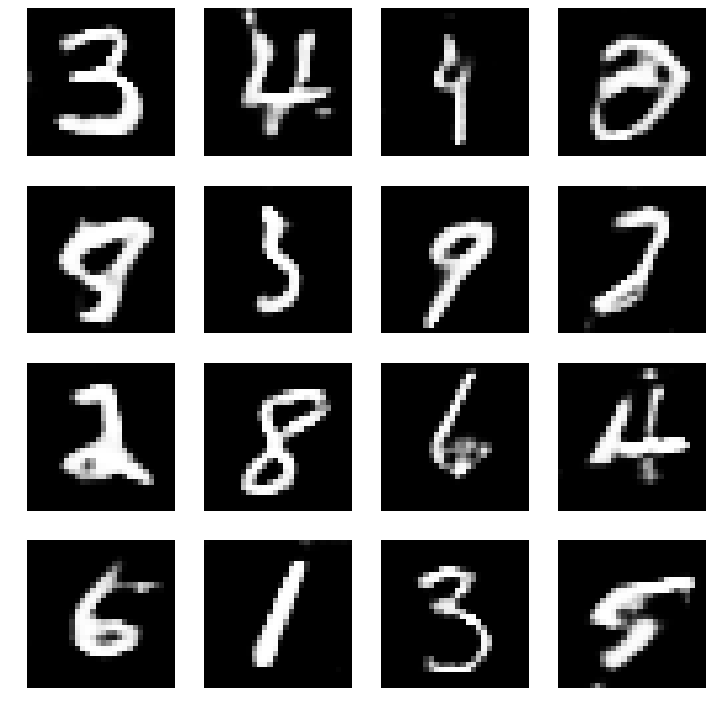

39000: [D loss: 0.614134, acc: 0.640625]  [A loss: 0.983135, acc: 0.234375]


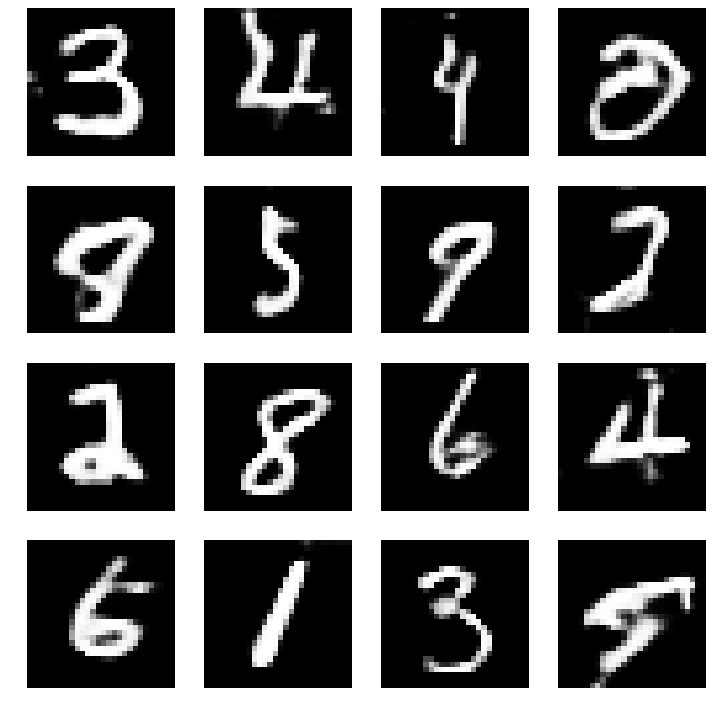

40000: [D loss: 0.663559, acc: 0.593750]  [A loss: 0.970260, acc: 0.218750]


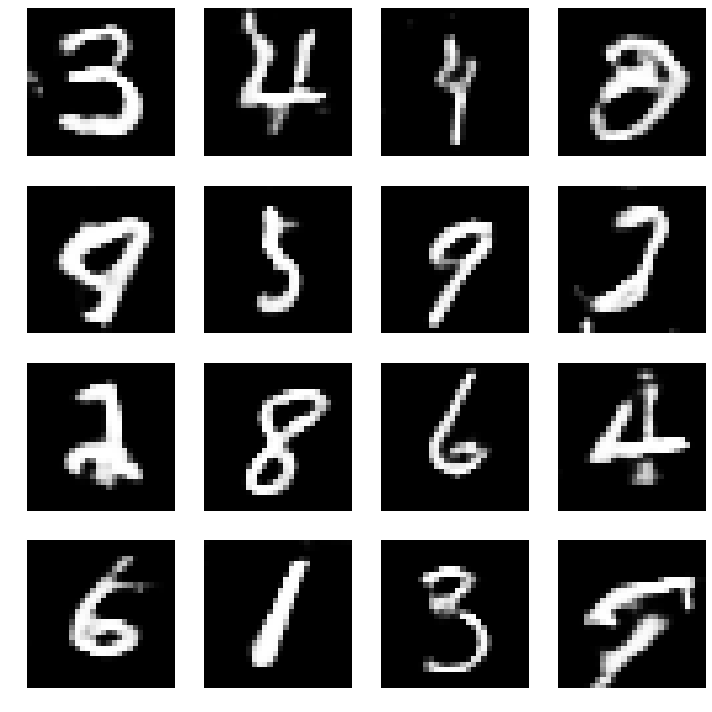

41000: [D loss: 0.582678, acc: 0.687500]  [A loss: 0.955684, acc: 0.296875]


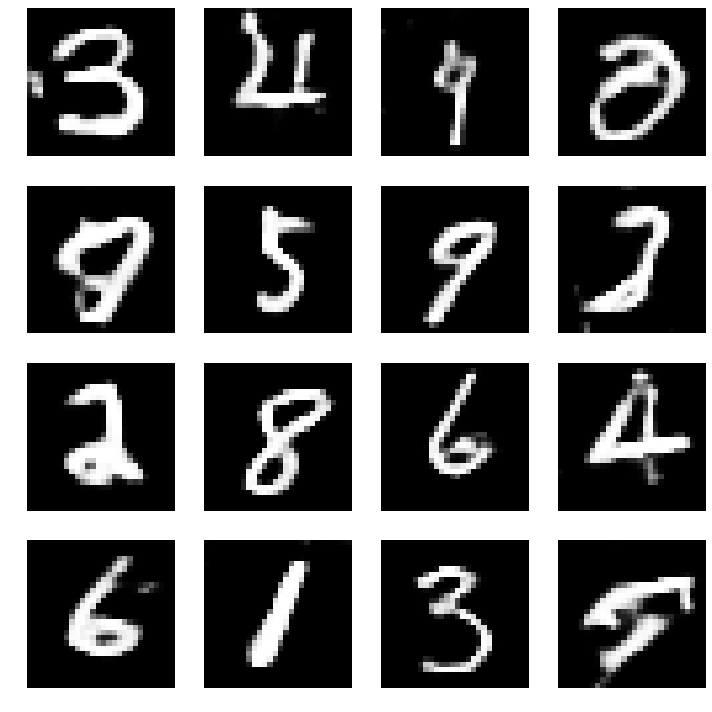

42000: [D loss: 0.609956, acc: 0.625000]  [A loss: 0.887181, acc: 0.281250]


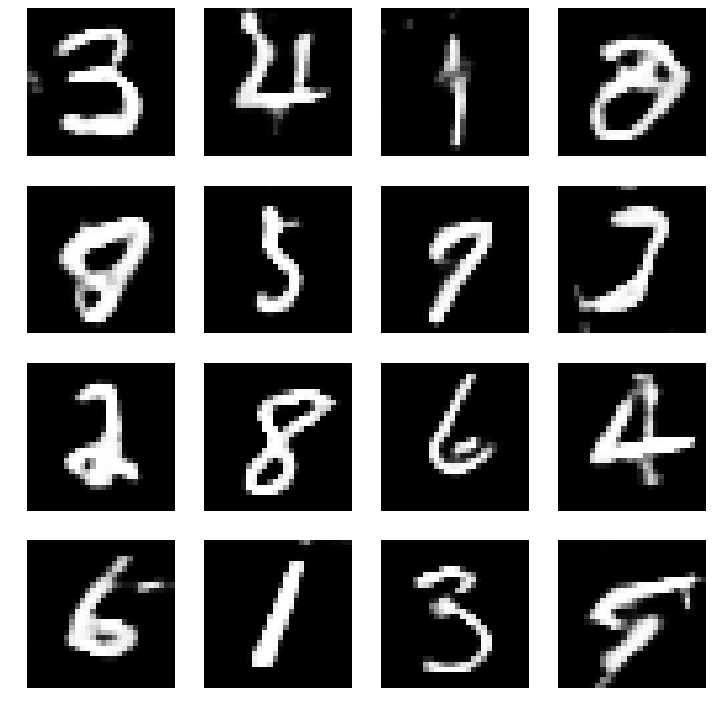

43000: [D loss: 0.595245, acc: 0.726562]  [A loss: 0.916701, acc: 0.265625]


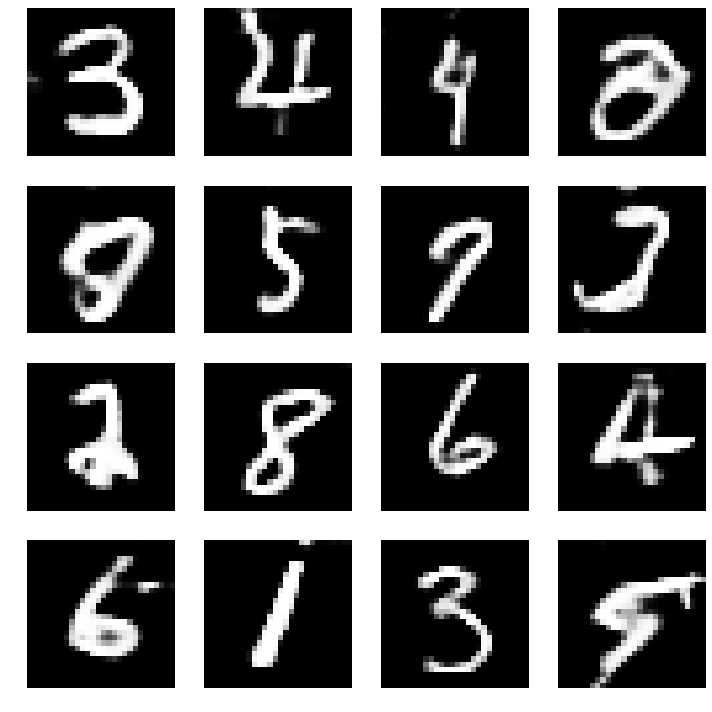

44000: [D loss: 0.649024, acc: 0.625000]  [A loss: 0.982962, acc: 0.281250]


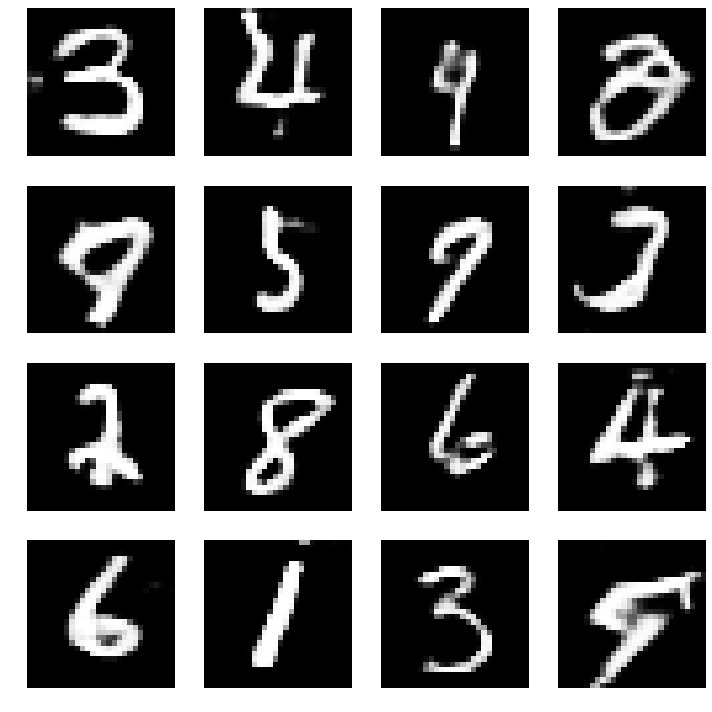

45000: [D loss: 0.615027, acc: 0.671875]  [A loss: 0.893507, acc: 0.250000]


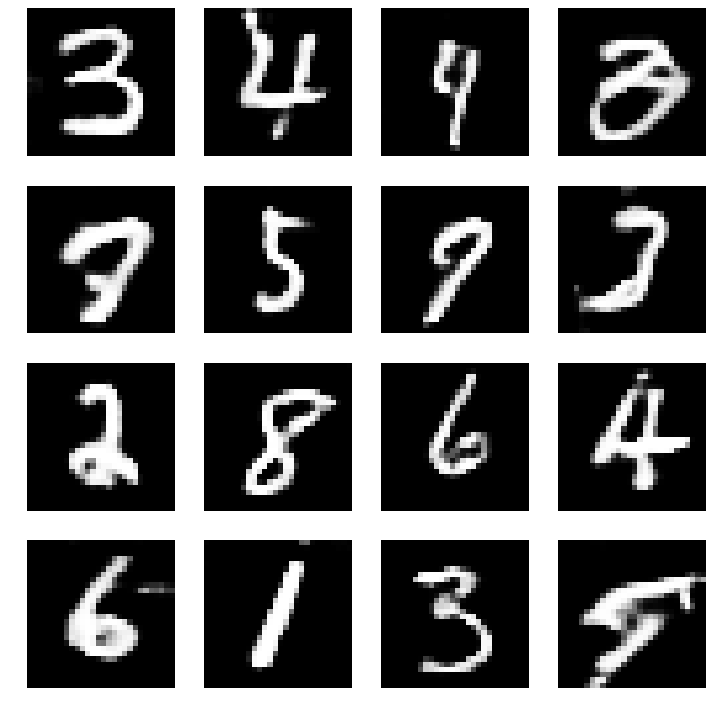

46000: [D loss: 0.635972, acc: 0.601562]  [A loss: 1.028699, acc: 0.187500]


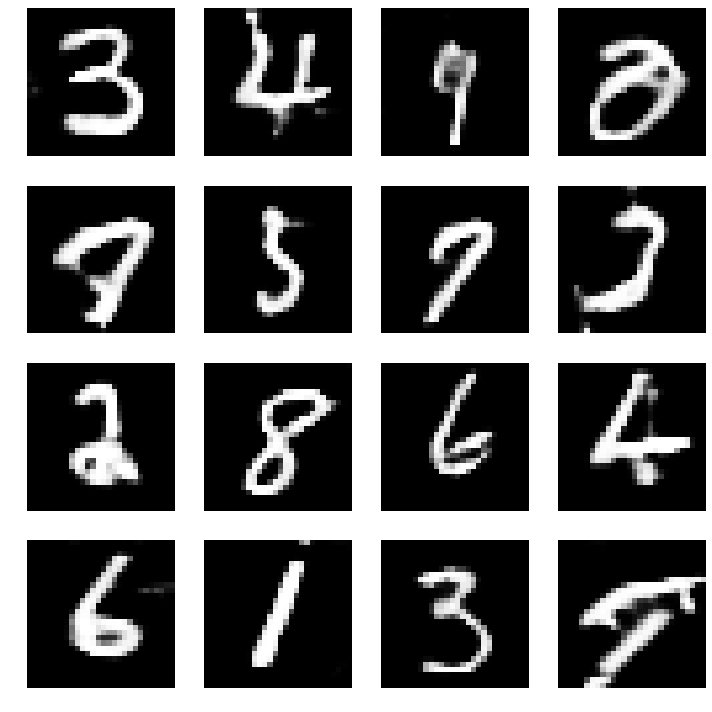

47000: [D loss: 0.680573, acc: 0.585938]  [A loss: 1.036548, acc: 0.203125]


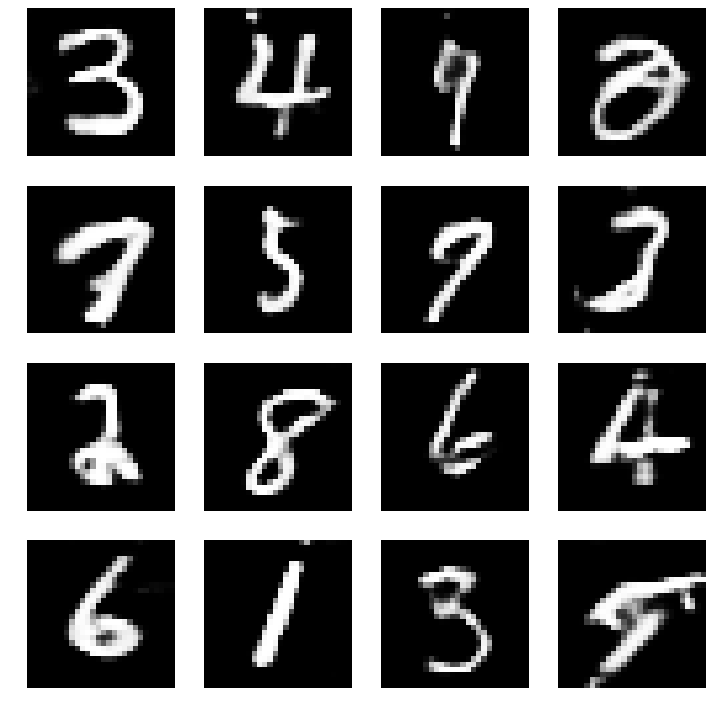

48000: [D loss: 0.645429, acc: 0.664062]  [A loss: 1.190284, acc: 0.078125]


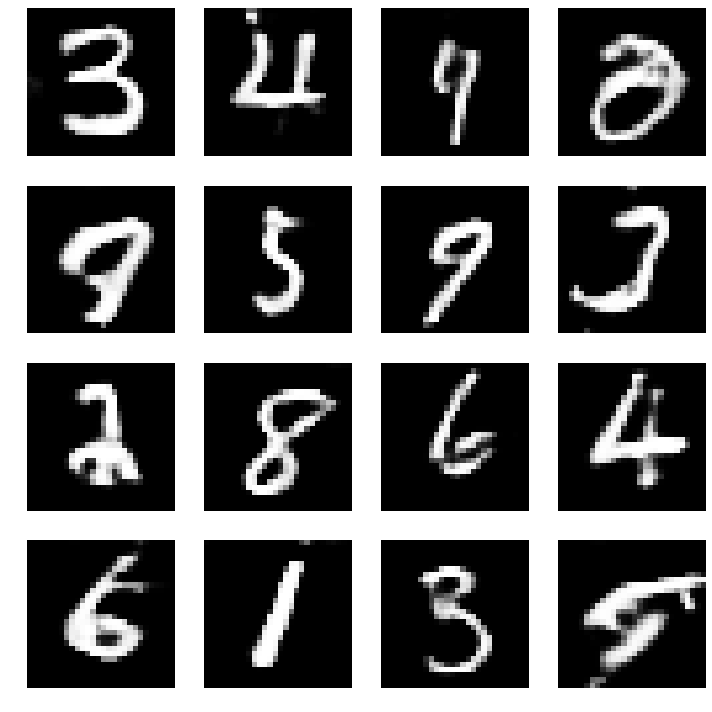

49000: [D loss: 0.638338, acc: 0.640625]  [A loss: 0.980519, acc: 0.171875]


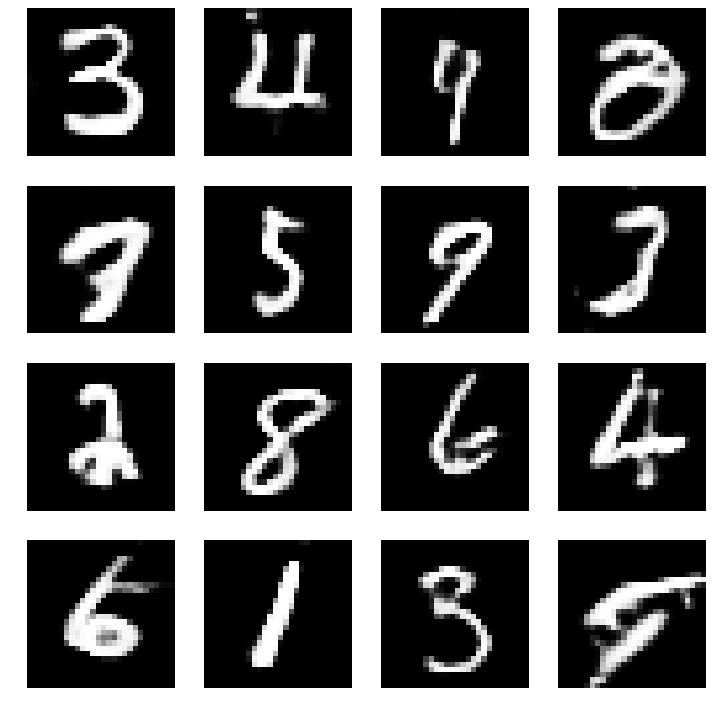

50000: [D loss: 0.639856, acc: 0.640625]  [A loss: 1.027854, acc: 0.203125]


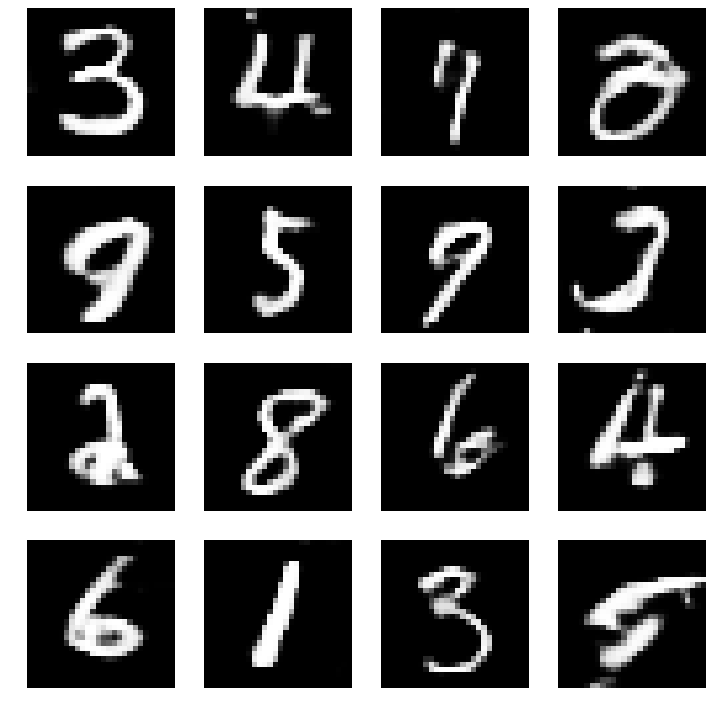

In [38]:
# Static noise to generate the training outup for supervision
noise_output = np.random.uniform(-1.0, 1.0, size=[16, 100])
  
for i in range(1, train_steps+1):
  if i % dis_training_interval == 0:
    d_loss = train_discriminator(Discriminator, Generator, x_train, batch_size)
  
  if i % gen_training_interval == 0:
    a_loss = train_generator(Adversarial, batch_size)
    
  if reduce_training_interval and i == train_steps // 2:
    gen_training_interval = gen_training_interval_reduction
    dis_training_interval = dis_training_interval_reduction
  
  if print_output_interval > 0:
    
    if i % print_output_interval == 0:
      
      log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
      log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
      print(log_mesg)
      
      plot_images(save_img=False,
                  samples=noise_output.shape[0], 
                  noise=noise_output, 
                  step=(i+1))

### Model storage

In [0]:
# Datetime for the filenames
currentDT = str(datetime.datetime.now())

# Storing directory
!mkdir "$currentDT"

D.save(currentDT + '/G ' + currentDT + '.h5')
D.save(currentDT + '/D ' + currentDT + '.h5')
Adversarial.save(currentDT + '/Adversarial ' + currentDT + '.h5')
Discriminator.save(currentDT + '/Discriminator ' + currentDT + '.h5')

plot_images(save_img=True, 
            filename=currentDT + '/generation ' + currentDT + ' ' + str(train_steps) + '.png',
            samples=noise_output.shape[0], 
            noise=noise_output, 
            step=(i+1))

## Result visualization

Here, a larger batch of generated images will be presented, to evaluate in a bigger scope the results of the model.

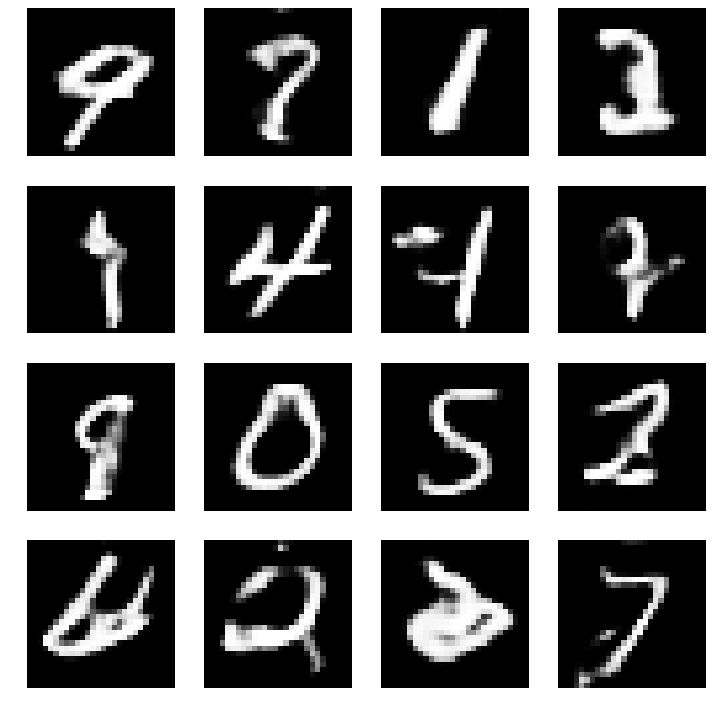

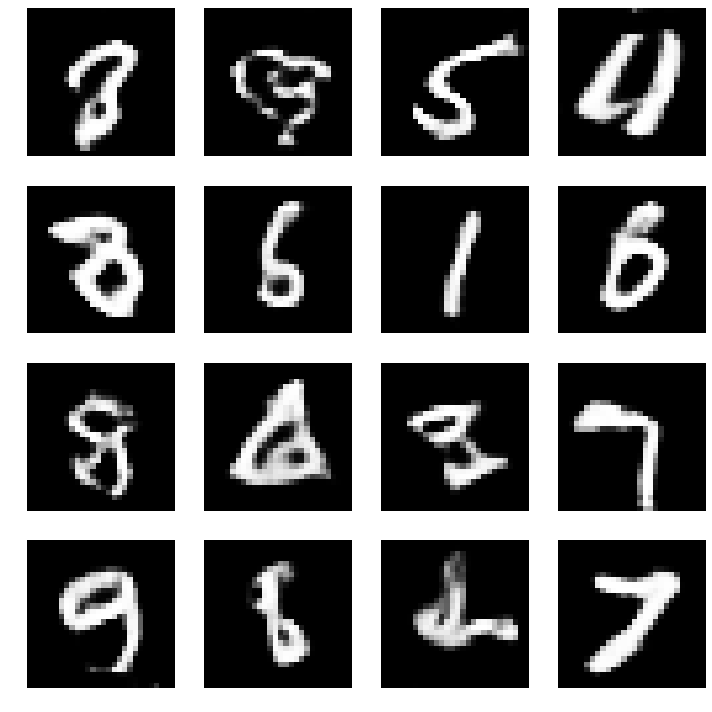

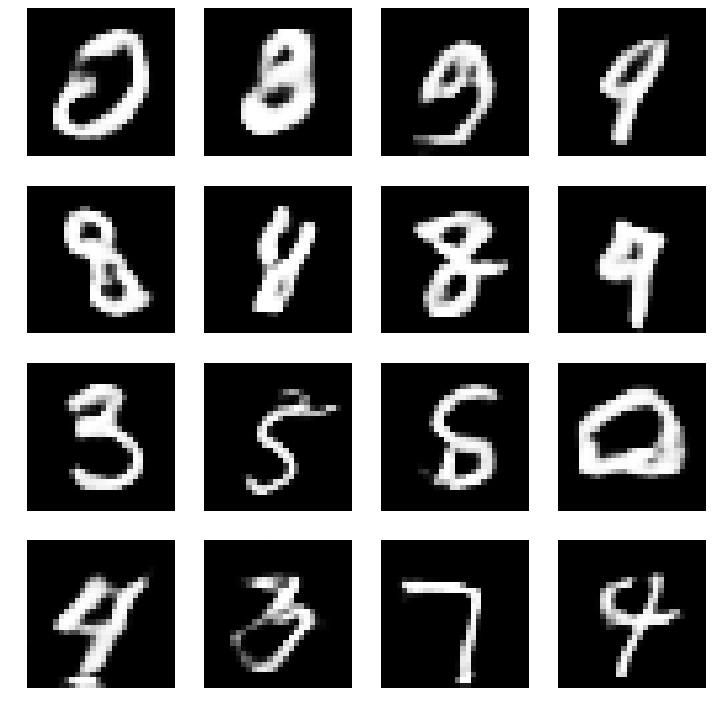

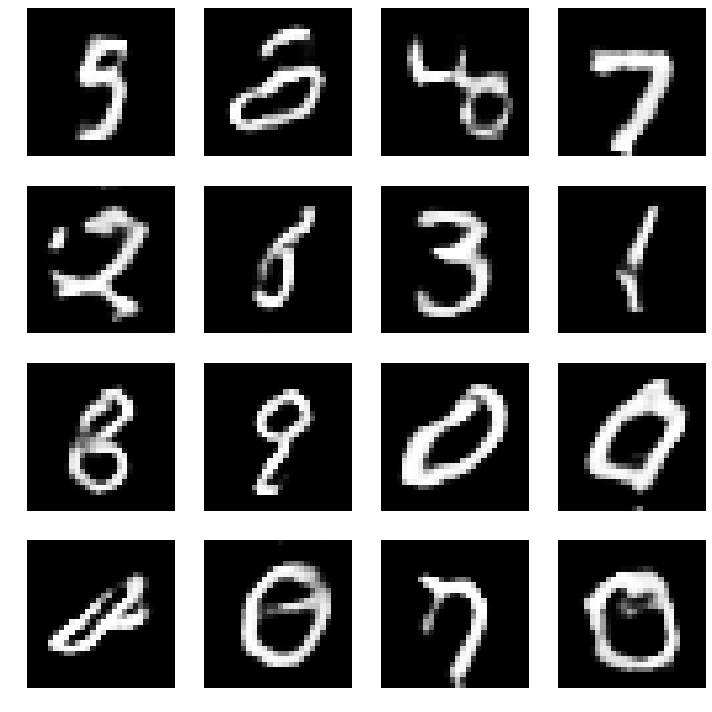

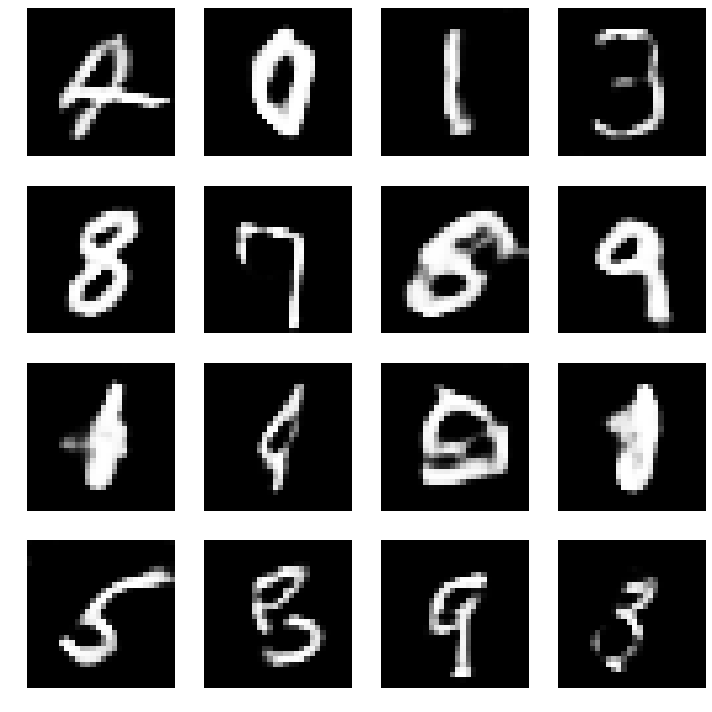

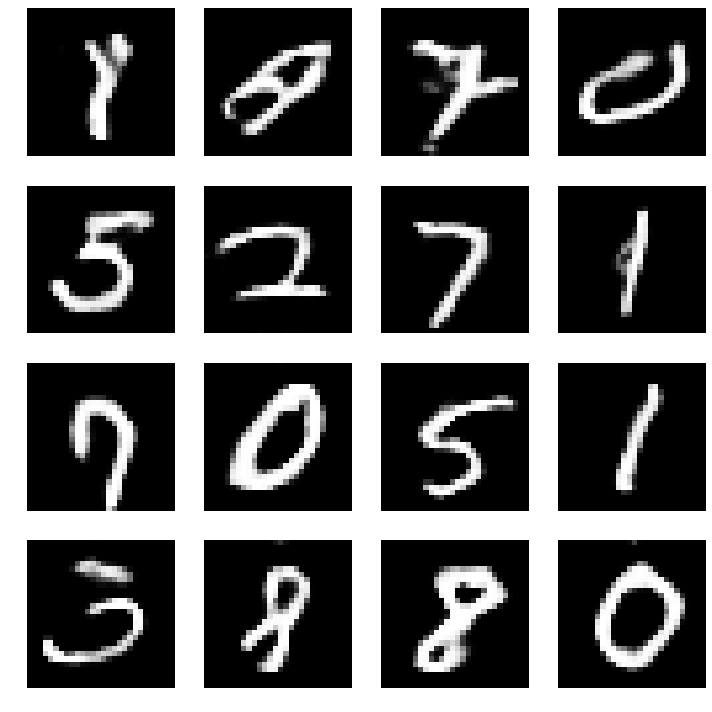

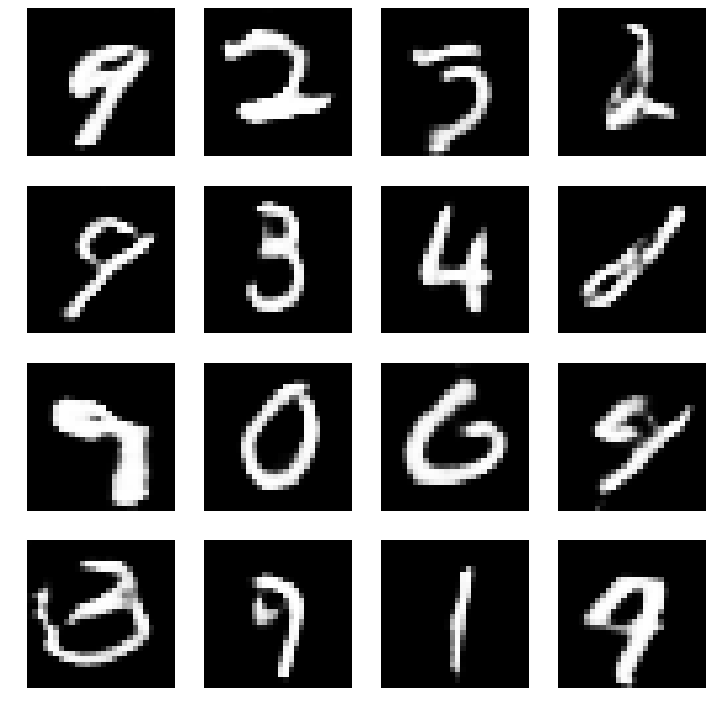

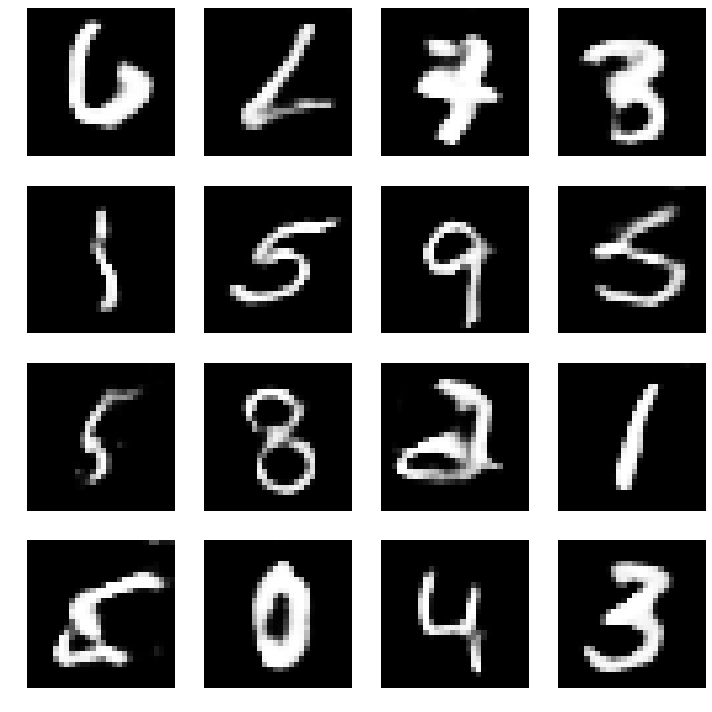

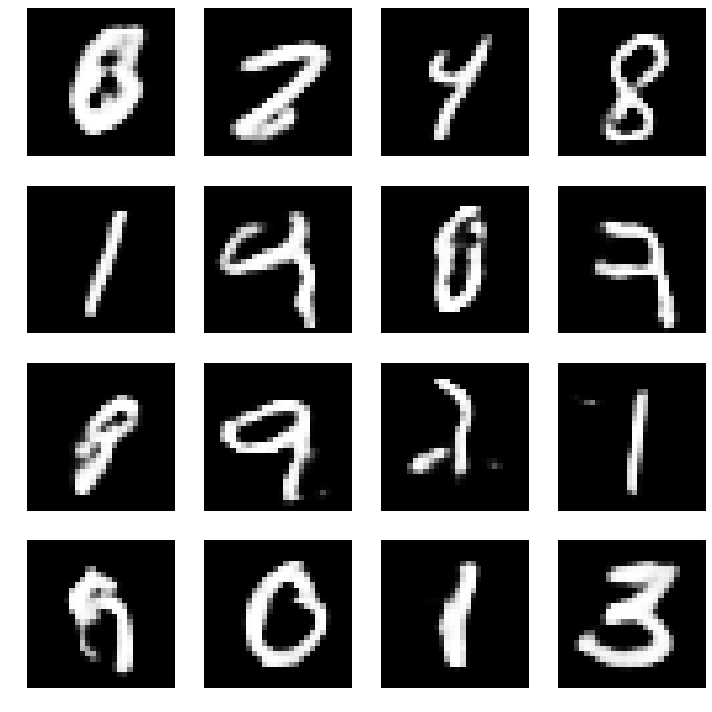

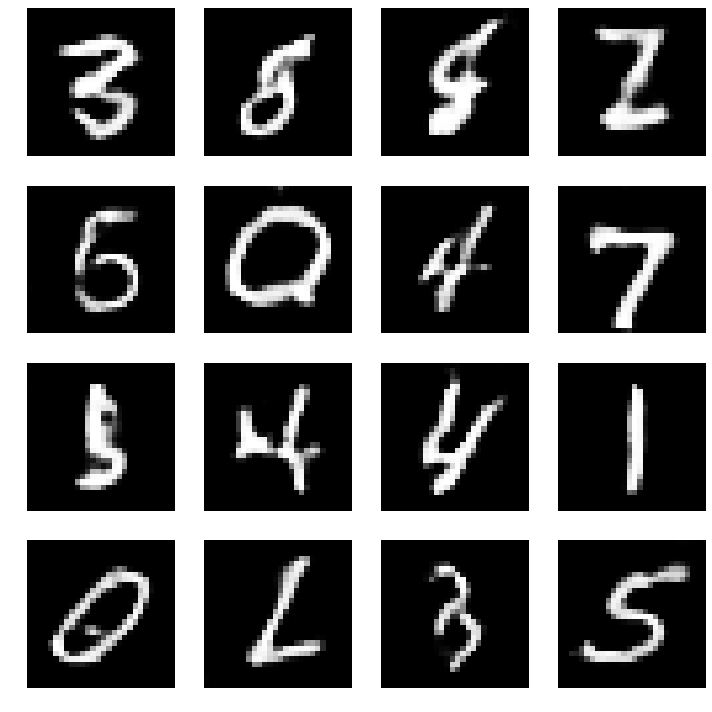

In [40]:
for i in range(10):
  plot_images(save_img=False,
              samples=noise_output.shape[0],
              step=train_steps)
